National Research University "Higher School of Economics"

Master of Data Science Online Programme

Master's Thesis

Topic: Electricity Spot Prices Forecasting Using Stochastic Volatility Models

Computations Notebook

Student: Andrei Batyrov (Fall2022)

Date: 07-May-2024

##### <a id="toc"></a>Table of Contents

1. [Description](#description)

2. [SV Baseline Model](#sv-base)

    2.1. [Price Data](#load-price-data)

    2.2. [Test For Stationarity](#price-data-adf)

    2.3. [Modeling](#model-sv-base)

    2.4. [Goodness-of-fit](#eval-sv-base)

3. [SV Exogenous Model](#sv-x)

    3.1. [Temperature Data](#load-temp-data)

    3.2. [Weekday](#load-weekday-data)

    3.3. [Modeling](#model-sv-x)

    3.4. [Goodness-of-fit](#eval-sv-x)

4. [Cross-validation](#cross-val)

    4.1. [SV Baseline](#cross-val-sv-base)

    4.2. [SV X](#cross-val-sv-x)

    4.3. [Model Comparison](#cross-val-comparison)

5. [Results](#results)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.cluster import KMeans
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm, probplot
from scipy.stats import ttest_ind, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from stan_model import StanModel
# This is needed to solve the problem with SSL certificates from www.atsenergo.ru
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

---
##### <a id="description"></a>1. Description

There are several approaches to modeling and forecasting time series as applied to prices of services, commodities, and derivative instruments. One of the approaches is to model the price as a heteroscedastic process with changing volatility (variance of price) over time.

In our scenario we will consider a typical Stochastic Volatility model that treats the volatility as a latent stochastic process in discrete time (Kim, Shephard, and Chib 1998) Kim, Sangjoon, Neil Shephard, and Siddhartha Chib. 1998. "Stochastic Volatility: Likelihood Inference and Comparison with ARCH Models." Review of Economic Studies 65: 361–93.

[Back](#toc)

---
##### <a id="sv-base"></a>2. SV Baseline Model

First, we will examine an **SV Baseline** model. This model can be described as a set of regression-like equations, with the following 4 parameters [Kim, Stan user's guide]:
- $\mu$, mean log volatility
- $\phi$, persistence of volatility
- $\sigma$, white noise shock scale
- $h_{t}$, latent log volatility at time $t$

The variable $\epsilon_{t}$ represents the white-noise shock (i.e., multiplicative error) on the price at time $t$, whereas $\delta_{t}$ represents the shock on volatility at time $t$:

$\epsilon_{t} \sim \mathcal{N}(0, 1)$; $\delta_{t} \sim \mathcal{N}(0, 1)$.

$\displaystyle y_{t} = e^{\frac{h_{t}}{2}} \epsilon_{t}$, where

$\displaystyle h_{t} = \mu + \phi (h_{t-1} - \mu) + \delta_{t} \sigma$,

$\displaystyle h_{1} \sim \mathcal{N} \left( \mu, \frac{\sigma}{\sqrt{1 - \phi^2}} \right)$.

To learn these 4 parameters from the price data, we will use the **Stan** platform for statistical modeling and high-performance statistical computation. It uses its own proprietary probabilistic language and can do Bayesian statistical inference, as well as maximum likelihood estimation (MLE) with derivative-based optimization (Newton, BFGS, etc.).
https://mc-stan.org/

Other notable probabilistic programming library is PyMC https://www.pymc.io/

Rearranging the equations above yields the following equations to be used in the Stan code for the SV Baseline model:

$\displaystyle y_{t} \sim \mathcal{N}(0, e^{\frac{h_{t}}{2}})$, where

$\displaystyle h_{1} \sim \mathcal{N} \left( \mu, \frac{\sigma}{\sqrt{1 - \phi^2}} \right)$,

$\displaystyle h_{t} \sim \mathcal{N}(\mu + \phi (h_{t-1} - \mu), \sigma)$,



##### <a id="load-price-data"></a>2.1. Price Data

There are two price zones: 1 (European) and 2 (Siberian) in the day-ahead spot electricity markets.
1. For building and examining our models, we will load the hourly data for the price zone 1 for the period 01.05.2023 -- 30.04.2024 (one year back from now) for the peak hour.
2. For model cross-validation, we will load and examine both price zones for both peak and off-peak hours with cross-validation over a sliding window for years 2014-2024.
3. For forecasting, we will generate predictions for both price zone for both peak and off-peak hours one day ahead.

The data is available on the АО "АТС" (Администратор Торговой Системы) platform https://www.atsenergo.ru/results/rsv/index, starting from Aug 8th, 2013 to present. The unit of prices is RUB/MWh (руб./МВт⋅ч).

In [2]:
price_zone = 1

In [3]:
# # We need to explicitly specify the column names to correctly parse the xml
# price_data = pd.read_xml(f'https://www.atsenergo.ru/market/stats.xml?period=0&date1=20230501&date2=20240430&zone={price_zone}&type=graph',
#                     names=['ROW_ID',
#                             'DAT',
#                             'PRICE_ZONE_CODE',
#                             'CONSUMER_VOLUME',
#                             'CONSUMER_PRICE',
#                             'CONSUMER_RD_VOLUME',
#                             'CONSUMER_SPOT_VOLUME',
#                             'CONSUMER_PROVIDE_RD',
#                             'CONSUMER_MAX_PRICE',
#                             'CONSUMER_MIN_PRICE',
#                             'SUPPLIER_VOLUME',
#                             'SUPPLIER_PRICE',
#                             'SUPPLIER_RD_VOLUME',
#                             'SUPPLIER_SPOT_VOLUME',
#                             'SUPPLIER_PROVIDE_RD',
#                             'SUPPLIER_MAX_PRICE',
#                             'SUPPLIER_MIN_PRICE',
#                             'HOUR'],
#                     xpath='//row',
#                     parse_dates=['DAT'])
# # Make datetime
# price_data = price_data.set_index(pd.to_datetime(price_data['DAT'].astype(str) + 'T' + price_data['HOUR'].astype(str) + ':00:00', dayfirst=True, errors='coerce'))
# price_data.index.name ='Datetime'
# # We can now drop all unnecessary columns to reduce the dataframe
# price_data = price_data.drop(columns=['ROW_ID',
#                         'DAT',
#                         'CONSUMER_VOLUME',
#                         'CONSUMER_RD_VOLUME',
#                         'CONSUMER_SPOT_VOLUME',
#                         'CONSUMER_PROVIDE_RD',
#                         'CONSUMER_MAX_PRICE',
#                         'CONSUMER_MIN_PRICE',
#                         'SUPPLIER_VOLUME',
#                         'SUPPLIER_PRICE',
#                         'SUPPLIER_RD_VOLUME',
#                         'SUPPLIER_SPOT_VOLUME',
#                         'SUPPLIER_PROVIDE_RD',
#                         'SUPPLIER_MAX_PRICE',
#                         'SUPPLIER_MIN_PRICE']).dropna()
# price_data = price_data.loc[~price_data.index.isna()].sort_index()
# price_data.to_csv('./data/price_data_20230501_20240430.csv')

In [132]:
price_data = pd.read_csv('./data/price_data_20230501_20240430.zip', index_col='Datetime', parse_dates=['Datetime'])

In [133]:
price_data.shape

(8784, 3)

In [6]:
price_data.head(4)

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR
Datetime,,,
2023-05-01 00:00:00,1,1517.92,0
2023-05-01 01:00:00,1,1413.99,1
2023-05-01 02:00:00,1,1345.22,2
2023-05-01 03:00:00,1,1275.81,3


In [7]:
price_data.tail(4)

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR
Datetime,,,
2024-04-30 20:00:00,1,1822.91,20
2024-04-30 21:00:00,1,1742.75,21
2024-04-30 22:00:00,1,1442.53,22
2024-04-30 23:00:00,1,1327.94,23


In [8]:
price_data.describe()

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR
count,8784.0,8784.000000,8784.000000
mean,1.0,1593.489557,11.500000
std,0.0,335.484863,6.922581
min,1.0,398.480000,0.000000
25%,1.0,1295.170000,5.750000
50%,1.0,1720.130000,11.500000
75%,1.0,1861.435000,17.250000
max,1.0,2504.960000,23.000000


In [9]:
#print(f'{year = }')

In [10]:
# Price zone 1 (European)
price_data_eur = price_data[price_data['PRICE_ZONE_CODE'] == 1]

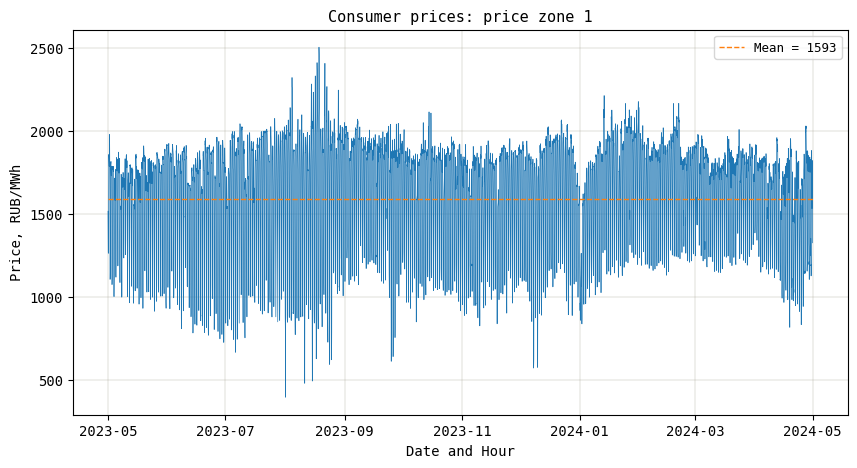

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(price_data_eur.index, price_data_eur['CONSUMER_PRICE'], color='C0', lw=0.5)
plt.hlines(price_data_eur['CONSUMER_PRICE'].mean(), xmin=price_data_eur.index.min(), xmax=price_data_eur.index.max(), color='C1', lw=1, ls='--', label=f"Mean = {price_data_eur['CONSUMER_PRICE'].mean():.0f}")
plt.xlabel('Date and Hour', size=10, family='monospace')
plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.title(f'Consumer prices: price zone {price_zone}', size=11, family='monospace')
plt.legend(prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement');

Next, we'll check the hour distribution -- consumer price mean hourly profile.

In [12]:
price_data_daily_agg_eur = price_data_eur.groupby('HOUR')['CONSUMER_PRICE'].mean()
price_data_daily_agg_eur

HOUR
0     1244.706885
1     1142.310683
2     1081.862240
3     1058.018962
4     1085.111284
5     1185.857131
6     1331.013224
7     1540.080082
8     1729.485519
9     1830.166311
10    1857.536230
11    1863.038005
12    1849.733060
13    1861.542568
14    1867.866858
15    1862.852432
16    1864.292022
17    1856.555902
18    1855.611311
19    1847.650683
20    1805.406421
21    1730.848115
22    1539.855820
23    1352.347623
Name: CONSUMER_PRICE, dtype: float64

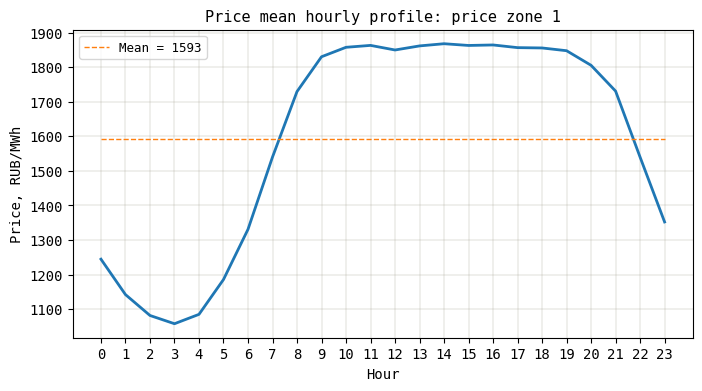

In [13]:
plt.figure(figsize=(8, 4))
plt.plot(price_data_daily_agg_eur.index, price_data_daily_agg_eur, color='C0', lw=2)
plt.hlines(price_data_daily_agg_eur.mean(), xmin=price_data_daily_agg_eur.index.min(), xmax=price_data_daily_agg_eur.index.max(), color='C1', lw=1, ls='--', label=f"Mean = {price_data_daily_agg_eur.mean():.0f}")
plt.xlabel('Hour', size=10, family='monospace')
plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
plt.xticks(price_data_daily_agg_eur.index, size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.title(f'Price mean hourly profile: price zone {price_zone}', size=11, family='monospace')
plt.legend(prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement');

Let's examine the peak and off-peak hours.

In [14]:
hour_max_eur = price_data_daily_agg_eur.idxmax()
hour_min_eur = price_data_daily_agg_eur.idxmin()
hour_max_eur, hour_min_eur

(14, 3)

In [15]:
price_data_peak_eur = price_data_eur[price_data_eur['HOUR'] == hour_max_eur]
price_data_peak_eur

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR
Datetime,,,
2023-05-01 14:00:00,1,1803.61,14
2023-05-02 14:00:00,1,1793.39,14
2023-05-03 14:00:00,1,1770.27,14
2023-05-04 14:00:00,1,1674.88,14
2023-05-05 14:00:00,1,1810.13,14
...,...,...,...
2024-04-26 14:00:00,1,1862.04,14
2024-04-27 14:00:00,1,2025.49,14
2024-04-28 14:00:00,1,1810.51,14


In [16]:
price_data_peak_eur['CONSUMER_PRICE'].describe()

count     366.000000
mean     1867.866858
std       137.479673
min      1132.110000
25%      1793.745000
50%      1869.885000
75%      1944.390000
max      2504.960000
Name: CONSUMER_PRICE, dtype: float64

In [17]:
price_data_offpeak_eur = price_data_eur[price_data_eur['HOUR'] == hour_min_eur]
price_data_offpeak_eur

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR
Datetime,,,
2023-05-01 03:00:00,1,1275.81,3
2023-05-02 03:00:00,1,1113.04,3
2023-05-03 03:00:00,1,1085.05,3
2023-05-04 03:00:00,1,1003.91,3
2023-05-05 03:00:00,1,1121.00,3
...,...,...,...
2024-04-26 03:00:00,1,944.52,3
2024-04-27 03:00:00,1,1147.59,3
2024-04-28 03:00:00,1,1157.11,3


In [18]:
price_data_offpeak_eur['CONSUMER_PRICE'].describe()

count     366.000000
mean     1058.018962
std       153.703503
min       495.830000
25%       956.015000
50%      1066.625000
75%      1182.727500
max      1435.760000
Name: CONSUMER_PRICE, dtype: float64

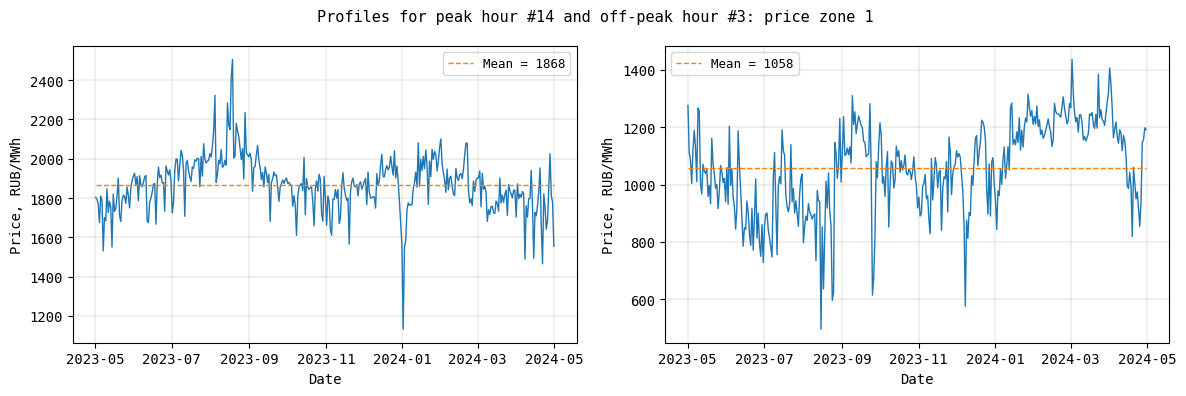

In [19]:
plt.figure(figsize=(12, 4))
for i, hour_profile in zip(range(1, 3), [price_data_peak_eur, price_data_offpeak_eur]):
    plt.subplot(1, 2, i)
    plt.plot(hour_profile.index, hour_profile['CONSUMER_PRICE'], color='C0', lw=1)
    plt.hlines(hour_profile['CONSUMER_PRICE'].mean(), xmin=hour_profile.index.min(), xmax=hour_profile.index.max(), color='C1', lw=1, ls='--', label=f"Mean = {hour_profile['CONSUMER_PRICE'].mean():.0f}")
    plt.xlabel('Date', size=10, family='monospace')
    plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
    plt.xticks(size=10, family='monospace')
    plt.yticks(size=10, family='monospace')
    plt.legend(prop={'size': 9, 'family': 'monospace'})
    plt.grid(lw=0.25, color='xkcd:cement');    
    plt.gca().set_axisbelow(True)
plt.suptitle(f'Profiles for peak hour #{hour_max_eur} and off-peak hour #{hour_min_eur}: price zone {price_zone}', size=11, family='monospace')
plt.tight_layout();

For further modeling we will consider only the peak hour. During cross-validation we will consider both peak and off-peak hours.

##### <a id="price-data-adf"></a>2.2. Test For Stationarity

Apply augmented Dickey-Fuller test for stationarity of price zone 1 (European)

$\mathcal{H}_{0}$: non-stationary

$\mathcal{H}_{1}$: stationary

In [20]:
alpha = 0.05
print(f'Peak hour #{hour_max_eur}:', end='    ')
adf_stats, adf_pval, _, _, _, _ = adfuller(price_data_peak_eur['CONSUMER_PRICE'])
print(f'{adf_stats = :.2f}, {adf_pval = :.2f}', end=', ')
print('Stationary') if adf_pval < alpha else print('Non-stationary')
print(f'Off-peak hour #{hour_min_eur}:', end=' ')
adf_stats, adf_pval, _, _, _, _ = adfuller(price_data_offpeak_eur['CONSUMER_PRICE'])
print(f'{adf_stats = :.2f}, {adf_pval = :.2f}', end=', ')
print('Stationary') if adf_pval < alpha else print('Non-stationary')

Peak hour #14:    adf_stats = -2.56, adf_pval = 0.10, Non-stationary
Off-peak hour #3: adf_stats = -2.71, adf_pval = 0.07, Non-stationary


##### <a id="model-sv-base"></a>2.3. Modeling

The mean of $y_{t}$ is modeled as $0$ in the original model, which means that we have to either centralize the data to make it oscillate around $0$ or change this parameter to reflect our data's real mean, which yields the following final SV Baseline model:

$\displaystyle y_{t} \sim \mathcal{N}(\bar{y}, e^{\frac{h_{t}}{2}})$.

We have created a custom wrapper class inheriting from the scikit-learn's <span style="font-family:consolas;">BaseEstimator</span> and <span style="font-family:consolas;">RegressorMixin</span> classes to work with our Stan models using the scikit-learn's interfaces: <span style="font-family:consolas;">fit()</span>, <span style="font-family:consolas;">predict()</span>, <span style="font-family:consolas;">score()</span>, <span style="font-family:consolas;">cross_validate()</span> etc.

In [21]:
# SV Baseline model
with open('./models/sv_base_fit.stan', 'r') as fh:
  sv_base_code_fit = fh.read()
with open('./models/sv_base_predict.stan', 'r') as fh:
  sv_base_code_predict = fh.read()
#print(sv_base_code_fit)
#print(sv_base_code_predict)
num_samples = 1_000
model_sv_base_peak_eur = StanModel(kind='sv_base',
                                  name='SV Baseline',
                                  stan_code_fit=sv_base_code_fit,
                                  stan_code_predict=sv_base_code_predict, 
                                  num_samples=num_samples)

In [22]:
%%capture
# Learn parameters
model_sv_base_peak_eur.fit(X=None, y=price_data_peak_eur['CONSUMER_PRICE'])

In [23]:
model_sv_base_peak_eur

StanModel(kind='sv_base', name='SV Baseline',
          stan_code_fit='// SV Baseline model\n'
                        '// Expected value: mean of y (constant)\n'
                        '// Volatility: stochastic\n'
                        '\n'
                        'data\n'
                        '{\n'
                        '  int<lower=1> N; // Number of train time points '
                        '(equally spaced)\n'
                        '  vector[N] y;    // Vector of train prices at time '
                        't\n'
                        '  real y_mean;    // Mean train price\n'
                        '}\n'
                        '\n'
                        'parameters\n'
                        '{\n'
                        '  real mu;                     // Mean log '
                        'volatili...
                            '// Volatility: stochastic\n'
                            '\n'
                            'data\n'
                            '{\n'
                            '  int<lower=1> N_pred; // Number of test time '
                            'points (equally spaced)\n'
                            '  vector[N_pred] h;    // Vector of learned log '
                            'volatility at time t\n'
                            '  real y_mean;         // Train mean price\n'
                            '}\n'
                            '\n'
                            'generated quantities\n'
                            '{\n'
                            '  vector[N_pred] y_pred;\n'
                            '\n'
                            '  // Predictions\n'
                            '  for (t in 1:N_pred)\n'
                            '  {\n'
                            '    y_pred[t] = normal_rng(y_mean, exp(h[t] / '
                            '2));  \n'
                            '  }\n'
                            '}')

In [24]:
fit_sv_base_peak_eur_df = model_sv_base_peak_eur.fit_result_df_
fit_sv_base_peak_eur_df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,phi,sigma,...,h.357,h.358,h.359,h.360,h.361,h.362,h.363,h.364,h.365,h.366
draws,,,,,,,,,,,,,,,,,,,,,
0,-2048.987072,0.998808,0.162794,5.0,31.0,0.0,2218.205321,9.409250,0.899576,0.510028,...,10.171760,9.761362,9.410159,9.572592,9.632585,9.607942,10.852149,11.492883,11.993282,11.938572
1,-2051.645520,0.785068,0.162794,5.0,31.0,0.0,2238.953193,9.487211,0.861444,0.689875,...,9.916836,10.182557,10.742638,10.911543,11.541358,11.319402,10.157329,9.669511,9.590177,10.396847
2,-2078.617586,0.936711,0.162794,5.0,31.0,0.0,2246.898599,9.033659,0.886703,0.533072,...,9.917153,9.708457,9.963123,10.795783,10.127860,10.138632,10.742932,9.514498,10.053345,10.269850
3,-2065.823102,0.974228,0.162794,5.0,31.0,0.0,2269.101908,9.373969,0.921994,0.538829,...,11.301413,10.719516,9.851357,10.527315,10.217348,9.208451,9.129752,8.981001,9.699747,9.606460
4,-2078.911922,0.623916,0.162794,5.0,31.0,0.0,2262.072333,9.597934,0.918899,0.561171,...,10.761057,10.848651,11.627593,11.226042,10.599984,10.524358,10.028912,10.298656,9.441375,10.218906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-2094.658510,0.841583,0.162794,5.0,31.0,0.0,2269.486505,9.886911,0.938825,0.432126,...,10.670229,10.366236,10.347617,10.578081,11.001728,10.715108,10.056712,10.122348,10.457994,10.961588
996,-2060.396429,0.995562,0.162794,5.0,31.0,0.0,2252.368033,8.966615,0.827554,0.529706,...,10.492312,10.430130,10.314677,10.100092,8.912153,8.933623,9.666055,9.420899,9.952453,10.233650
997,-2056.457131,0.962217,0.162794,5.0,31.0,0.0,2239.633281,9.132582,0.895557,0.511179,...,9.955513,9.563039,9.598079,9.270466,10.243102,10.128444,9.285494,9.729757,9.800248,10.017575


In [25]:
# Learned parameters
fit_sv_base_peak_eur_df[['mu', 'phi', 'sigma']].describe()

parameters,mu,phi,sigma
count,1000.000000,1000.000000,1000.000000
mean,9.348617,0.881165,0.499893
std,0.275783,0.048779,0.107231
min,8.276047,0.715244,0.212606
25%,9.173458,0.853809,0.423141
50%,9.339528,0.888114,0.496753
75%,9.520876,0.916686,0.563613
max,10.401829,0.983804,0.889206


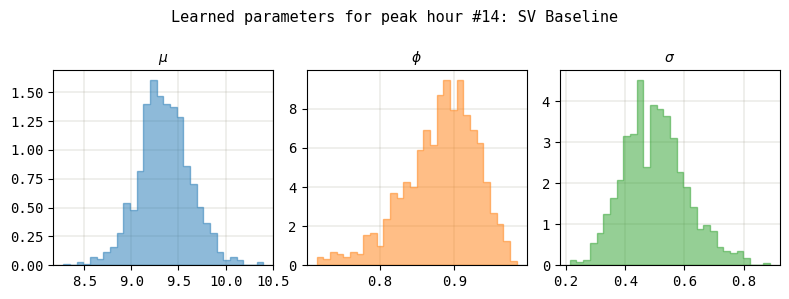

In [26]:
plt.figure(figsize=(8, 3))
for i, param in zip(range(1, 4), fit_sv_base_peak_eur_df[['mu', 'phi', 'sigma']].describe().columns):
    plt.subplot(1, 3, i)
    plt.hist(fit_sv_base_peak_eur_df[param], bins=30, density=True, histtype='stepfilled', color=f'C{i - 1}', edgecolor=f'C{i - 1}', alpha=0.5)
    plt.xticks(size=10, family='monospace')
    plt.yticks(size=10, family='monospace')
    plt.title(f'$\{param}$', size=10, family='monospace')
    plt.grid(lw=0.25, color='xkcd:cement')
    plt.gca().set_axisbelow(True)
plt.suptitle(f'Learned parameters for peak hour #{hour_max_eur}: {model_sv_base_peak_eur.name}', size=11, family='monospace')
plt.tight_layout();

In [27]:
%%capture
# Predict
predict_sv_base_peak_eur_mean = model_sv_base_peak_eur.predict(price_data_peak_eur['CONSUMER_PRICE'])
predict_sv_base_peak_eur_mean.shape

In [28]:
%%capture
predict_sv_base_peak_eur_many = model_sv_base_peak_eur.predict_many(price_data_peak_eur['CONSUMER_PRICE'])
predict_sv_base_peak_eur_many.shape

In [29]:
%%capture
predict_sv_base_peak_eur_ci = model_sv_base_peak_eur.predict_ci(price_data_peak_eur['CONSUMER_PRICE'], [2.5, 97.5])
len(predict_sv_base_peak_eur_ci)

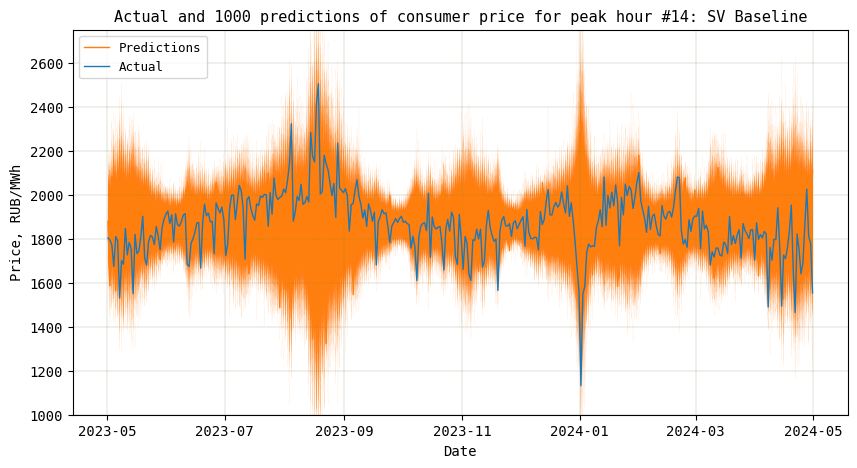

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(price_data_peak_eur.index, predict_sv_base_peak_eur_many.iloc[0], color='C1', lw=1, label='Predictions')
for i in range(1, predict_sv_base_peak_eur_many.shape[0]):
    plt.plot(price_data_peak_eur.index, predict_sv_base_peak_eur_many.iloc[i], color='C1', lw=0.025)
plt.plot(price_data_peak_eur.index, price_data_peak_eur['CONSUMER_PRICE'], color='C0', lw=1, label='Actual')
plt.xlabel('Date', size=10, family='monospace')
plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.ylim([1000, 2750])
plt.title(f'Actual and {num_samples} predictions of consumer price for peak hour #{hour_max_eur}: {model_sv_base_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='upper left', prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement');

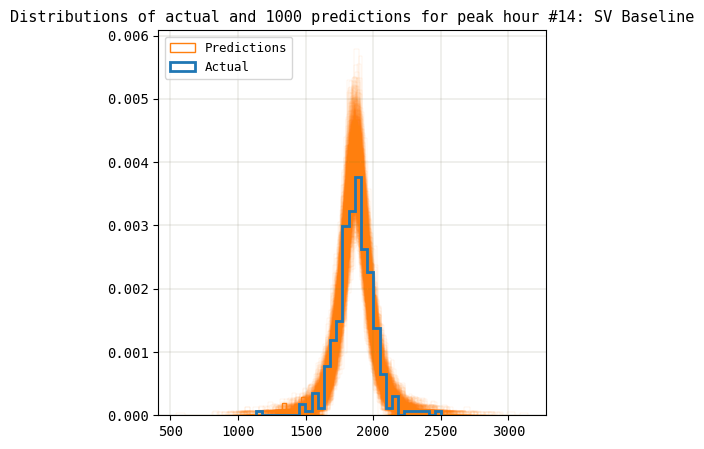

In [31]:
plt.figure(figsize=(5, 5))
plt.hist(predict_sv_base_peak_eur_many.iloc[0], bins=30, density=True, histtype='step', color='white', edgecolor='C1', lw=1, label='Predictions')
for i in range(1, predict_sv_base_peak_eur_many.shape[0]):
    plt.hist(predict_sv_base_peak_eur_many.iloc[i], bins=30, density=True, histtype='step', color='white', edgecolor='C1', lw=0.05)
plt.hist(price_data_peak_eur['CONSUMER_PRICE'], bins=30, density=True, histtype='step', color='white', edgecolor='C0', lw=2, label='Actual')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.grid(lw=0.25, color='xkcd:cement')
plt.legend(loc='upper left', prop={'size': 9, 'family': 'monospace'})
plt.gca().set_axisbelow(True)
plt.title(f'Distributions of actual and {num_samples} predictions for peak hour #{hour_max_eur}: {model_sv_base_peak_eur.name}', size=11, family='monospace');

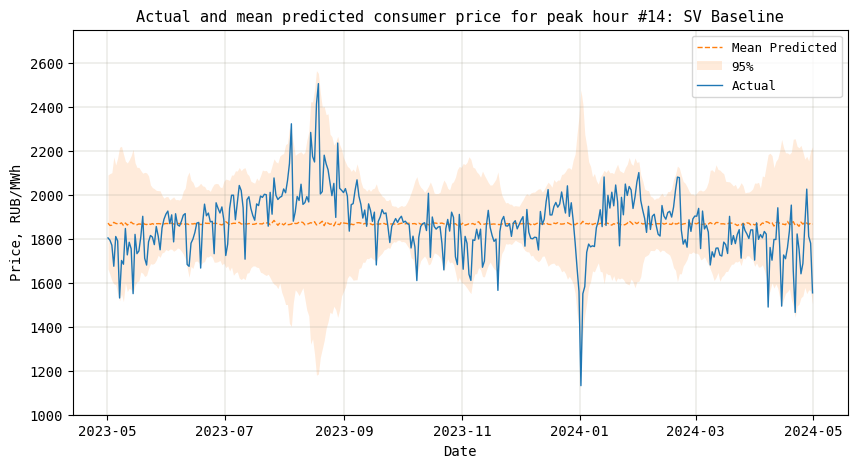

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(price_data_peak_eur.index, predict_sv_base_peak_eur_mean, color='C1', lw=1, ls='--', label='Mean Predicted')
plt.fill_between(price_data_peak_eur.index, predict_sv_base_peak_eur_ci[0], predict_sv_base_peak_eur_ci[1], color='C1', lw=0, alpha=0.15, label='95%')
plt.plot(price_data_peak_eur.index, price_data_peak_eur['CONSUMER_PRICE'], color='C0', lw=1, label='Actual')
plt.xlabel('Date', size=10, family='monospace')
plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.ylim([1000, 2750])
plt.title(f'Actual and mean predicted consumer price for peak hour #{hour_max_eur}: {model_sv_base_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'});
plt.grid(lw=0.25, color='xkcd:cement');

In [33]:
# Volatility at time t over all predictions
vol_sv_base_peak_eur = model_sv_base_peak_eur.get_volatility()
vol_sv_base_peak_eur.shape

(1000, 366)

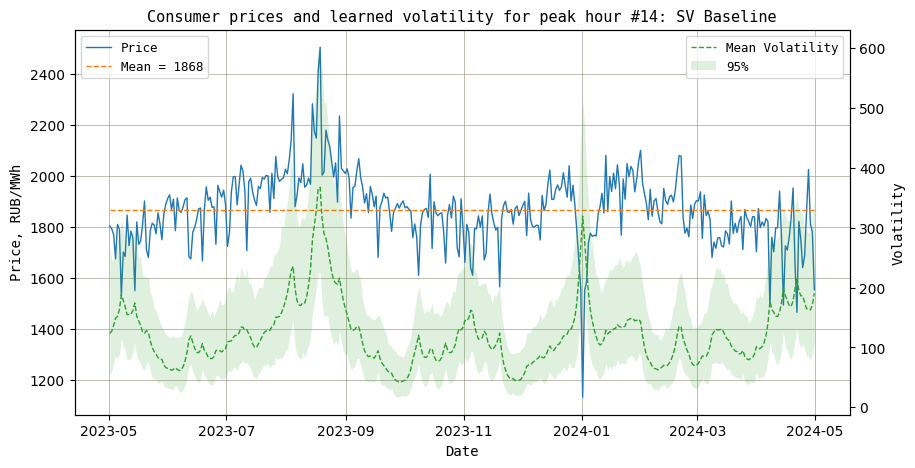

In [34]:
_, ax = plt.subplots(figsize=(10, 5))
ax.plot(price_data_peak_eur.index, price_data_peak_eur['CONSUMER_PRICE'], color='C0', lw=1, label='Price')
ax.hlines(price_data_peak_eur['CONSUMER_PRICE'].mean(), xmin=price_data_peak_eur.index.min(), xmax=price_data_peak_eur.index.max(), color='C1', lw=1, ls='--', label=f"Mean = {price_data_peak_eur['CONSUMER_PRICE'].mean():.0f}")
ax.set_xlabel('Date', size=10, family='monospace')
ax.set_ylabel('Price, RUB/MWh', size=10, family='monospace')
ax.legend(loc='upper left', prop={'size': 9, 'family': 'monospace'})
ax.grid(lw=0.5, color='xkcd:cement')
ax2 = ax.twinx()
ax2.plot(price_data_peak_eur.index, vol_sv_base_peak_eur.mean(axis=0), color='C2', lw=1, ls='--', label='Mean Volatility')
ax2.fill_between(price_data_peak_eur.index, np.percentile(vol_sv_base_peak_eur, [2.5, 97.5], axis=0)[0], np.percentile(vol_sv_base_peak_eur, [2.5, 97.5], axis=0)[1], color='C2', lw=0, alpha=0.15, label='95%')
ax2.set_ylabel('Volatility', size=10, family='monospace')
ax2.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
ax.set_title(f'Consumer prices and learned volatility for peak hour #{hour_max_eur}: {model_sv_base_peak_eur.name}', size=11, family='monospace');

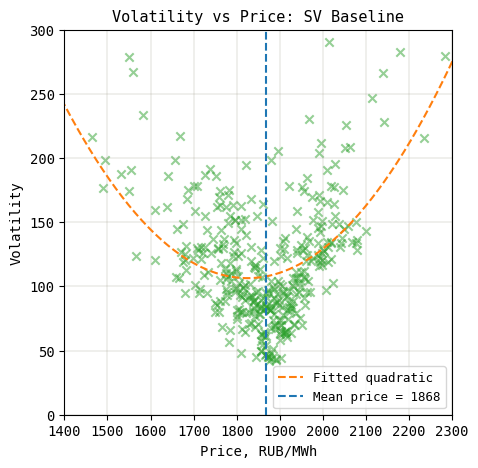

In [35]:
plt.figure(figsize=(5, 5))
fitted_quadratic = np.poly1d(np.polyfit(price_data_peak_eur['CONSUMER_PRICE'], vol_sv_base_peak_eur.mean(axis=0), deg=2))
x = np.linspace(price_data_peak_eur['CONSUMER_PRICE'].min(), price_data_peak_eur['CONSUMER_PRICE'].max(), price_data_peak_eur['CONSUMER_PRICE'].shape[0])
plt.scatter(price_data_peak_eur['CONSUMER_PRICE'], vol_sv_base_peak_eur.mean(axis=0), color='C2', marker='x', alpha=0.5)
plt.plot(x, fitted_quadratic(x), color='C1', ls='--', label='Fitted quadratic')
plt.vlines(price_data_peak_eur['CONSUMER_PRICE'].mean(), ymin=0, ymax=350, color='C0', ls='--', label=f"Mean price = {price_data_peak_eur['CONSUMER_PRICE'].mean():.0f}")
plt.xlabel('Price, RUB/MWh', size=10, family='monospace')
plt.ylabel('Volatility', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.xlim([1400, 2300])
plt.ylim([0, 300])
plt.title(f'Volatility vs Price: {model_sv_base_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='lower right', prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement');

In [36]:
alpha = 0.05
adf_stats, adf_pval, _, _, _, _ = adfuller(vol_sv_base_peak_eur.mean(axis=0))
print(f'{adf_stats = :.2f}, {adf_pval = :.2f}', end=', ')
print('Stationary') if adf_pval < alpha else print('Non-stationary')

adf_stats = -2.83, adf_pval = 0.05, Non-stationary


We can clearly see that volatility _does_ depend on consumer price, and our **SV Baseline** model discovered this relation.

We can see a rather V-shaped dependency: the volatility tends to increase for the prices higher and lower than the mean price, while it's minimal around the mean price.

##### <a id="eval-sv-base"></a>2.4. Goodness-of-fit

Consider the following metrics for evaluating the quality of the model.

1) Mean Absolute Error: $\displaystyle MAE = \frac{1}{n} \sum_{i=1}^{n} |y_{i} - \hat{y_{i}}|$, where

    $n$ is the number of target points, $y_{i}$ are the true target values, $\hat{y_{i}}$ are the model's predictions.
2) Rooted Mean Squared Error: $\displaystyle RMSE = \sqrt{MSE}$, where 

    Mean Squared Error: $\displaystyle MSE = \frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y_{i}})^2$.

In [37]:
# MAE for mean predictions over all predictions
mae_sv_base = mean_absolute_error(price_data_peak_eur['CONSUMER_PRICE'], predict_sv_base_peak_eur_mean)
mae_sv_base

99.18284666027084

In [38]:
# RMSE for mean predictions over all predictions
rmse_sv_base = root_mean_squared_error(price_data_peak_eur['CONSUMER_PRICE'], predict_sv_base_peak_eur_mean)
rmse_sv_base

137.04160239198836

Let's check the correlation between mean predicted and actual prices.

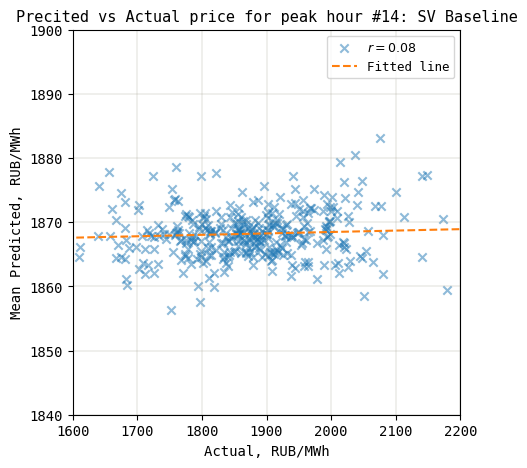

In [39]:
r = np.corrcoef(price_data_peak_eur['CONSUMER_PRICE'], predict_sv_base_peak_eur_mean)[0, 1]
fitted_line = np.poly1d(np.polyfit(price_data_peak_eur['CONSUMER_PRICE'], predict_sv_base_peak_eur_mean, deg=1))
x = np.linspace(price_data_peak_eur['CONSUMER_PRICE'].min(), price_data_peak_eur['CONSUMER_PRICE'].max(), price_data_peak_eur['CONSUMER_PRICE'].shape[0])
plt.figure(figsize=(5, 5))
plt.scatter(price_data_peak_eur['CONSUMER_PRICE'], predict_sv_base_peak_eur_mean, color='C0', marker='x', alpha=0.5, label=f'$r = {r:.2f}$')
plt.plot(x, fitted_line(x), color='C1', ls='--', label='Fitted line')
plt.xlabel('Actual, RUB/MWh', size=10, family='monospace')
plt.ylabel('Mean Predicted, RUB/MWh', size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.xlim([1600, 2200])
plt.ylim([1840, 1900])
plt.title(f'Precited vs Actual price for peak hour #{hour_max_eur}: {model_sv_base_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement');

Though the model was able to learn heteroscedasity of the volatility, the correlation between the mean predictions and actual prices is rather weak.

We should also check the distribution of residuals, probability plot (similar to Q-Q plot), and residuals vs mean predicted prices.

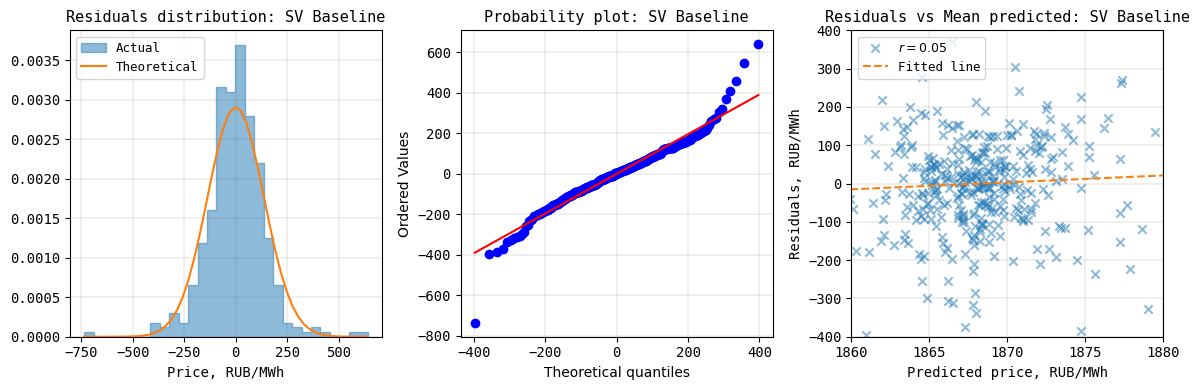

In [40]:
residuals_sv_base = price_data_peak_eur['CONSUMER_PRICE'] - predict_sv_base_peak_eur_mean.values
x = np.linspace(residuals_sv_base.min(), residuals_sv_base.max())
residuals_sv_base_theor = norm(residuals_sv_base.mean(), residuals_sv_base.std(ddof=1))
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(residuals_sv_base, bins=30, density=True, histtype='stepfilled', color='C0', edgecolor='C0', alpha=0.5, label='Actual')
plt.plot(x, residuals_sv_base_theor.pdf(x), color='C1', label='Theoretical')
plt.xlabel('Price, RUB/MWh', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.title(f'Residuals distribution: {model_sv_base_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='upper left', prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement')
plt.gca().set_axisbelow(True)
plt.subplot(1, 3, 2)
probplot(residuals_sv_base, dist=residuals_sv_base_theor, plot=plt)
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.title(f'Probability plot: {model_sv_base_peak_eur.name}', size=11, family='monospace')
plt.grid(lw=0.25, color='xkcd:cement')
plt.gca().set_axisbelow(True)
plt.subplot(1, 3, 3)
r = np.corrcoef(residuals_sv_base, predict_sv_base_peak_eur_mean)[0, 1]
fitted_line = np.poly1d(np.polyfit(predict_sv_base_peak_eur_mean, residuals_sv_base, deg=1))
x = np.linspace(predict_sv_base_peak_eur_mean.min(), predict_sv_base_peak_eur_mean.max(), predict_sv_base_peak_eur_mean.shape[0])
plt.scatter(predict_sv_base_peak_eur_mean, residuals_sv_base, color='C0', marker='x', alpha=0.5, label=f'$r = {r:.2f}$')
plt.plot(x, fitted_line(x), color='C1', ls='--', label='Fitted line')
plt.xlabel('Predicted price, RUB/MWh', size=10, family='monospace')
plt.ylabel('Residuals, RUB/MWh', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.xlim([1860, 1880])
plt.ylim([-400, 400])
plt.title(f'Residuals vs Mean predicted: {model_sv_base_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='upper left', prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement')
plt.gca().set_axisbelow(True)
plt.tight_layout();

Residuals look to be distributed more or less normally. Also they look rather homoscedastic w.r.t predictions, which means that the model is rather acceptable.

[Back](#toc)

---
##### <a id="sv-x"></a>3. SV Exogenous Model

Next, we will consider an extension of the SV Baseline model. The idea of adding exogenous regressor(s) is inspired by the paper "Probabilistic electricity price forecasting with Bayesian stochastic volatility models" by Maciej Kostrzewski, Jadwiga Kostrzewska, 2019.

The authors propose a stochastic volatility model with a double exponential distribution of jumps, a leverage effect and exogenous variables (in short, the SVDEJX model). This model introduces one exogenous factor -- the logarithm of the hourly air temperature at time $t$. The model also introduces indicator variables for 3 days of the week: Sat, Sun, Mon, and volatility jumps.

First, we'll examine the first possible exogenous regressor -- air temperature.

##### <a id="load-temp-data"></a>3.1. Temperature Data

In [134]:
# Price zone 1: Moscow
temp_data_eur = pd.read_csv(f'./data/UUEE.01.05.2023.30.04.2024.1.0.0.ru.utf8.00000000.zip', 
                        sep=';', 
                        encoding='utf-8',
                        skiprows=7, 
                        index_col=0, 
                        dayfirst=True, 
                        usecols=[0, 1], 
                        names=['Datetime', 'Temperature'], 
                        parse_dates=True).dropna().sort_index()

In [135]:
temp_data_eur

,Temperature
Datetime,
2023-05-01 00:00:00,6.0
2023-05-01 00:30:00,6.0
2023-05-01 01:00:00,6.0
2023-05-01 01:30:00,6.0
2023-05-01 02:00:00,6.0
...,...
2024-04-30 21:30:00,18.0
2024-04-30 22:00:00,19.0
2024-04-30 22:30:00,19.0


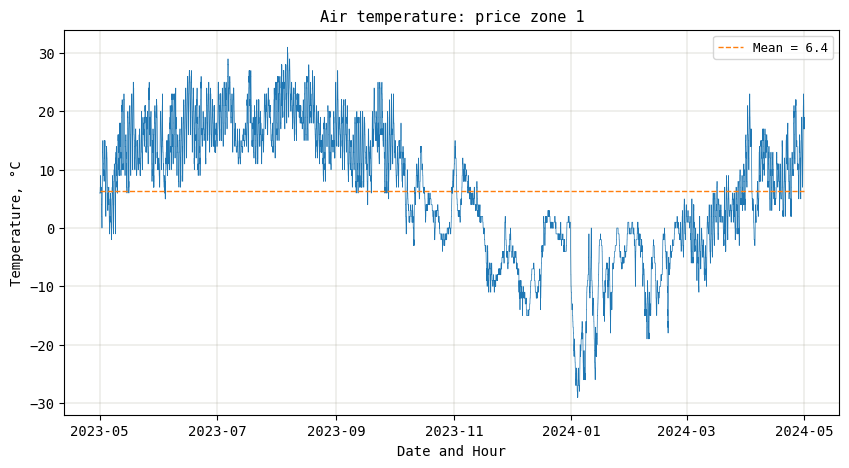

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(temp_data_eur.index, temp_data_eur['Temperature'], color='C0', lw=0.5)
plt.hlines(temp_data_eur['Temperature'].mean(), xmin=temp_data_eur.index.min(), xmax=temp_data_eur.index.max(), color='C1', lw=1, ls='--', label=f"Mean = {temp_data_eur['Temperature'].mean():.1f}")
plt.xlabel('Date and Hour', size=10, family='monospace')
plt.ylabel('Temperature, °C', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.title(f'Air temperature: price zone {price_zone}', size=11, family='monospace')
plt.legend(prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement');

In [44]:
# Join consumer price and air temperature data
price_temp_data = pd.merge(price_data, temp_data_eur, on='Datetime')
price_temp_data.shape

(8760, 4)

In [45]:
price_temp_data.head(4)

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR,Temperature
Datetime,,,,
2023-05-01 00:00:00,1,1517.92,0,6.0
2023-05-01 01:00:00,1,1413.99,1,6.0
2023-05-01 02:00:00,1,1345.22,2,6.0
2023-05-01 03:00:00,1,1275.81,3,6.0


In [46]:
price_temp_data.tail(4)

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR,Temperature
Datetime,,,,
2024-04-30 20:00:00,1,1822.91,20,18.0
2024-04-30 21:00:00,1,1742.75,21,17.0
2024-04-30 22:00:00,1,1442.53,22,19.0
2024-04-30 23:00:00,1,1327.94,23,18.0


In [47]:
price_temp_data_eur = price_temp_data[price_temp_data['PRICE_ZONE_CODE'] == 1]

In [48]:
price_temp_data_peak_eur = price_temp_data_eur[price_temp_data_eur['HOUR'] == hour_max_eur]
price_temp_data_peak_eur

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR,Temperature
Datetime,,,,
2023-05-01 14:00:00,1,1803.61,14,7.0
2023-05-02 14:00:00,1,1793.39,14,14.0
2023-05-03 14:00:00,1,1770.27,14,12.0
2023-05-04 14:00:00,1,1674.88,14,13.0
2023-05-05 14:00:00,1,1810.13,14,4.0
...,...,...,...,...
2024-04-26 14:00:00,1,1862.04,14,22.0
2024-04-27 14:00:00,1,2025.49,14,10.0
2024-04-28 14:00:00,1,1810.51,14,15.0


In [49]:
price_temp_data_offpeak_eur = price_temp_data_eur[price_temp_data_eur['HOUR'] == hour_min_eur]
price_temp_data_offpeak_eur

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR,Temperature
Datetime,,,,
2023-05-01 03:00:00,1,1275.81,3,6.0
2023-05-02 03:00:00,1,1113.04,3,2.0
2023-05-03 03:00:00,1,1085.05,3,9.0
2023-05-04 03:00:00,1,1003.91,3,4.0
2023-05-05 03:00:00,1,1121.00,3,5.0
...,...,...,...,...
2024-04-26 03:00:00,1,944.52,3,11.0
2024-04-27 03:00:00,1,1147.59,3,15.0
2024-04-28 03:00:00,1,1157.11,3,6.0


Let's check the correlation between the Price and Temperature. We are expecting a rather V-shaped dependency, since both high and low air temperatures should increase electricity demand for cooling and heating and thus the price.

/tmp/ipykernel_21039/4233981735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_temp_data_peak_eur.loc[:, 'Cluster'] = KMeans(n_clusters=2, random_state=0).fit_predict(price_temp_data_peak_eur[['Temperature']])


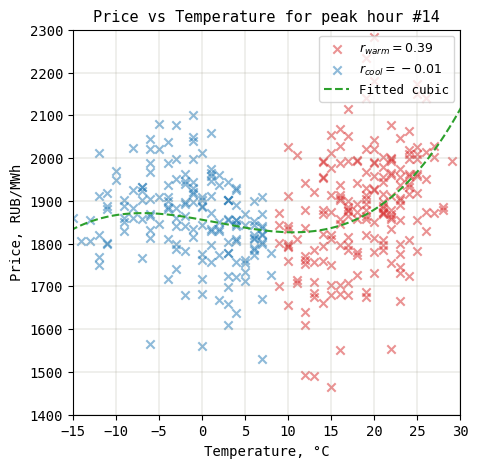

In [50]:
price_temp_data_peak_eur.loc[:, 'Cluster'] = KMeans(n_clusters=2, random_state=0).fit_predict(price_temp_data_peak_eur[['Temperature']])
r_warm = price_temp_data_peak_eur[price_temp_data_peak_eur['Cluster'] == price_temp_data_peak_eur['Cluster'].max()]['CONSUMER_PRICE'].corr(price_temp_data_peak_eur[price_temp_data_peak_eur['Cluster'] == price_temp_data_peak_eur['Cluster'].max()]['Temperature'])
r_cool = price_temp_data_peak_eur[price_temp_data_peak_eur['Cluster'] == price_temp_data_peak_eur['Cluster'].min()]['CONSUMER_PRICE'].corr(price_temp_data_peak_eur[price_temp_data_peak_eur['Cluster'] == price_temp_data_peak_eur['Cluster'].min()]['Temperature'])
fitted_cubic = np.poly1d(np.polyfit(price_temp_data_peak_eur['Temperature'], price_temp_data_peak_eur['CONSUMER_PRICE'], deg=3))
x = np.linspace(price_temp_data_peak_eur['Temperature'].min(), price_temp_data_peak_eur['Temperature'].max(), price_temp_data_peak_eur['Temperature'].shape[0])
plt.figure(figsize=(5, 5))
plt.scatter(price_temp_data_peak_eur[price_temp_data_peak_eur['Cluster'] == price_temp_data_peak_eur['Cluster'].max()]['Temperature'], price_temp_data_peak_eur[price_temp_data_peak_eur['Cluster'] == price_temp_data_peak_eur['Cluster'].max()]['CONSUMER_PRICE'], color='C3', marker='x', alpha=0.5, label=f'$r_{{warm}} = {r_warm:.2f}$')
plt.scatter(price_temp_data_peak_eur[price_temp_data_peak_eur['Cluster'] == price_temp_data_peak_eur['Cluster'].min()]['Temperature'], price_temp_data_peak_eur[price_temp_data_peak_eur['Cluster'] == price_temp_data_peak_eur['Cluster'].min()]['CONSUMER_PRICE'], color='C0', marker='x', alpha=0.5, label=f'$r_{{cool}} = {r_cool:.2f}$')
plt.plot(x, fitted_cubic(x), color='C2', ls='--', label='Fitted cubic')
plt.xlabel('Temperature, °C', size=10, family='monospace')
plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.xlim([-15, 30])
plt.ylim([1400, 2300])
plt.title(f'Price vs Temperature for peak hour #{hour_max_eur}', size=11, family='monospace')
plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement');

We can confirm that the price _does_ depend on the air temperature:
- coefficient of correlation (Pearson) for high air temperatures is 0.39,
- coefficient of correlation (Pearson) for low air temperatures is -0.01.

The price tends to be higher for higher and lower air temperatures, which looks reasonable: electricity demand is higher during the hot and cold season of the year (both cooling and heating are required), while the demand is minimal during semi-seasons when minimal heating and cooling are required. At the same time, the price responds more to the higher air temperatures. This might be due to the fact that in the studied scenario electricity is used more for cooling than for heating.

Next, let's examine the day of the week.

##### <a id="load-weekday-data"></a>3.2. Weekday

In [51]:
price_temp_data_peak_eur['day_name'] = price_temp_data_peak_eur.index.day_name()
price_temp_data_peak_eur['Weekday'] = price_temp_data_peak_eur.index.day_of_week
price_temp_data_peak_eur

/tmp/ipykernel_21039/672662706.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_temp_data_peak_eur['day_name'] = price_temp_data_peak_eur.index.day_name()
/tmp/ipykernel_21039/672662706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_temp_data_peak_eur['Weekday'] = price_temp_data_peak_eur.index.day_of_week


,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR,Temperature,Cluster,day_name,Weekday
Datetime,,,,,,,
2023-05-01 14:00:00,1,1803.61,14,7.0,0,Monday,0
2023-05-02 14:00:00,1,1793.39,14,14.0,1,Tuesday,1
2023-05-03 14:00:00,1,1770.27,14,12.0,1,Wednesday,2
2023-05-04 14:00:00,1,1674.88,14,13.0,1,Thursday,3
2023-05-05 14:00:00,1,1810.13,14,4.0,0,Friday,4
...,...,...,...,...,...,...,...
2024-04-26 14:00:00,1,1862.04,14,22.0,1,Friday,4
2024-04-27 14:00:00,1,2025.49,14,10.0,1,Saturday,5
2024-04-28 14:00:00,1,1810.51,14,15.0,1,Sunday,6


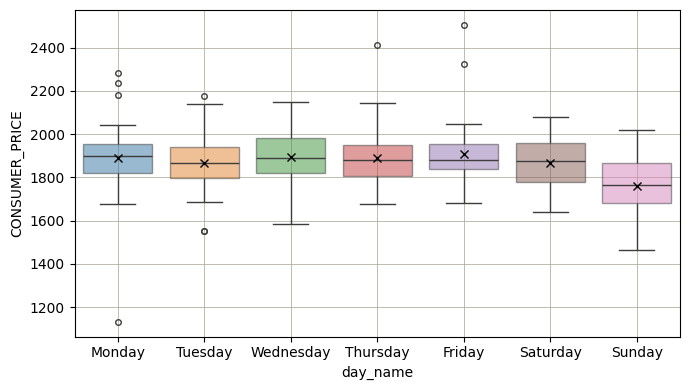

In [52]:
plt.figure(figsize=(7, 4))
sns.boxplot(data=price_temp_data_peak_eur[['CONSUMER_PRICE', 'Weekday', 'day_name']].sort_values(by='Weekday'), x='day_name', y='CONSUMER_PRICE', hue='day_name', flierprops={'marker': 'o', 'markersize': 4}, showmeans=True, meanprops={'marker': 'x', 'markeredgecolor': 'k', 'markerfacecolor': 'k', 'markersize': 6}, boxprops=dict(alpha=0.5))
plt.grid(lw=0.5, color='xkcd:cement')
plt.tight_layout();

Though the mean values look equal, at least on Sundays the price tends to be lower. Let's introduce the second new regressor -- day of week.

We have shown that the consumer price is correlated with both the air temperature and day of week. Let's propose a new model **SV X**, which extends the ideas of our regression-like SV Baseline model and [Kostrzewski] with two exogenous regressors -- air temperature and day of week:

$\displaystyle y_{t} \sim \mathcal{N}(\bar{y} + \beta_3 X_{t-1}^3 + \beta_2 X_{t-1}^2 + \beta_1 X_{t-1} + \beta_0 + \gamma D_{t}, e^{\frac{h_{t}}{2}})$, where

$X_{t-1}$ is the hourly air temperature at time $t-1$. To prevent target leakage, the temperature readings are lagged one day behind ($t-1$);

$D_{t}$ is the day of week at time $t$;

$\displaystyle h_{t} \sim \mathcal{N}(\mu + \phi (h_{t-1} - \mu), \sigma)$;

$\displaystyle h_{1} \sim \mathcal{N} \left( \mu, \frac{\sigma}{\sqrt{1 - \phi^2}} \right)$.

Thus, we are introducing:
- 4 new parameters: $\beta_{i = 0 \ldots 3}$ of the air temperature regressor. The unit of air temperature is °C;
- 1 new parameter: $\gamma$ for the day of week regressor. The weekdays are numbered from 0 (Monday) to 6 (Sunday).

##### <a id="model-sv-x"></a>3.3. Modeling

In [53]:
# SV Exogenous model
with open('./models/sv_x_fit.stan', 'r') as fh:
  sv_x_code_fit = fh.read()
with open('./models/sv_x_predict.stan', 'r') as fh:
  sv_x_code_predict = fh.read()
#print(sv_x_code_fit)
#print(sv_x_code_predict)
num_samples = 1_000
model_sv_x_peak_eur = StanModel(kind='sv_x', 
                                name='SV X',
                                stan_code_fit=sv_x_code_fit,
                                stan_code_predict=sv_x_code_predict, 
                                num_samples=num_samples)

In [54]:
%%capture
# Learn parameters
model_sv_x_peak_eur.fit(X=price_temp_data_peak_eur[['Temperature', 'Weekday']], y=price_temp_data_peak_eur['CONSUMER_PRICE'])

In [55]:
model_sv_x_peak_eur

StanModel(kind='sv_x', name='SV X',
          stan_code_fit='// SV Exogenous model\n'
                        '// Expected value: mean of y (constant)\n'
                        '// Volatility: stochastic\n'
                        '// Exogenous regressor(s)\n'
                        '\n'
                        'data\n'
                        '{\n'
                        '  int<lower=1> N; // Number of train time points '
                        '(equally spaced)\n'
                        '  vector[N] y;    // Vector of train prices at time '
                        't\n'
                        '  real y_mean;    // Mean train price\n'
                        '  vector[N] Temperature;    // Vector of train...
                            '  // So predict the first value as simply the '
                            'mean and continue from index 2\n'
                            '  y_pred[1] = normal_rng(y_mean + gamma * '
                            'Weekday_pred[1], exp(h[1] / 2));\n'
                            '  for (t in 2:N_pred)\n'
                            '  {\n'
                            '    y_pred[t] = normal_rng(y_mean + \n'
                            '                           beta_3 * '
                            'pow(Temperature_pred[t - 1], 3) + \n'
                            '                           beta_2 * '
                            'pow(Temperature_pred[t - 1], 2) + \n'
                            '                           beta_1 * '
                            'Temperature_pred[t - 1] + \n'
                            '                           beta_0 +\n'
                            '                           gamma * '
                            'Weekday_pred[t], \n'
                            '                           exp(h[t] / 2));\n'
                            '  }\n'
                            '}')

In [56]:
fit_sv_x_peak_eur_df = model_sv_x_peak_eur.fit_result_df_
fit_sv_x_peak_eur_df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,phi,sigma,...,h.357,h.358,h.359,h.360,h.361,h.362,h.363,h.364,h.365,h.366
draws,,,,,,,,,,,,,,,,,,,,,
0,-2036.854876,0.965747,0.100694,5.0,31.0,0.0,2199.991834,9.190300,0.757920,0.582723,...,9.204705,9.473393,9.507401,10.044656,9.408855,9.345397,9.456488,8.666337,9.778787,10.825281
1,-2030.948627,0.977540,0.100694,6.0,63.0,0.0,2221.919003,9.016305,0.838634,0.622674,...,10.318946,9.118099,8.821037,8.389065,8.961310,9.076769,9.604934,10.766165,10.407833,10.774900
2,-2027.676511,0.991870,0.100694,6.0,63.0,0.0,2202.541000,9.223326,0.854668,0.533759,...,10.369954,10.146747,9.946835,10.267428,9.476805,9.551187,9.515880,8.794289,10.049322,11.069744
3,-2014.864110,0.918742,0.100694,6.0,63.0,0.0,2193.308700,9.123523,0.836873,0.701476,...,10.673417,9.774592,9.827872,9.586596,10.351440,10.474346,11.092160,12.035884,11.430663,11.359835
4,-2008.297621,0.967661,0.100694,5.0,31.0,0.0,2192.373031,9.132194,0.828315,0.638029,...,10.467533,9.743767,9.760587,9.382307,10.043358,10.198949,10.507236,11.448286,10.687571,10.701289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-2018.092679,0.908886,0.100694,6.0,63.0,0.0,2214.817547,8.875647,0.769329,0.821858,...,9.630742,9.427837,10.187140,10.155067,9.794349,9.773126,10.068630,10.467770,10.916975,10.979952
996,-1999.323352,0.897425,0.100694,6.0,63.0,0.0,2206.313709,9.138100,0.886249,0.654292,...,10.570582,9.776896,9.744757,9.977961,9.552868,10.163845,10.270514,9.752531,10.216225,11.190396
997,-1994.416903,0.959090,0.100694,6.0,63.0,0.0,2174.548705,8.777466,0.831051,0.899225,...,10.236576,10.734207,11.568166,11.579931,11.826111,10.501209,9.874442,11.421742,11.345354,11.193969


In [57]:
# Learned parameters
fit_sv_x_peak_eur_df[['mu', 'phi', 'sigma', 'beta_0', 'beta_1', 'beta_2', 'beta_3', 'gamma']].describe()

parameters,mu,phi,sigma,beta_0,beta_1,beta_2,beta_3,gamma
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,9.080835,0.852776,0.587029,26.238634,-4.175537,0.005448,0.013374,-16.355246
std,0.261279,0.054968,0.115106,9.138535,0.947707,0.054256,0.002884,2.240935
min,8.263822,0.617173,0.273179,1.656619,-7.847229,-0.177422,0.004148,-23.739238
25%,8.910113,0.816712,0.506826,19.992724,-4.787747,-0.029208,0.011498,-17.894615
50%,9.077997,0.856085,0.582401,26.039767,-4.158445,0.001728,0.013427,-16.384103
75%,9.241580,0.893068,0.659098,32.516938,-3.564895,0.036733,0.015240,-14.736899
max,10.294638,0.983433,1.071097,59.704903,-1.345120,0.181243,0.021888,-9.126177


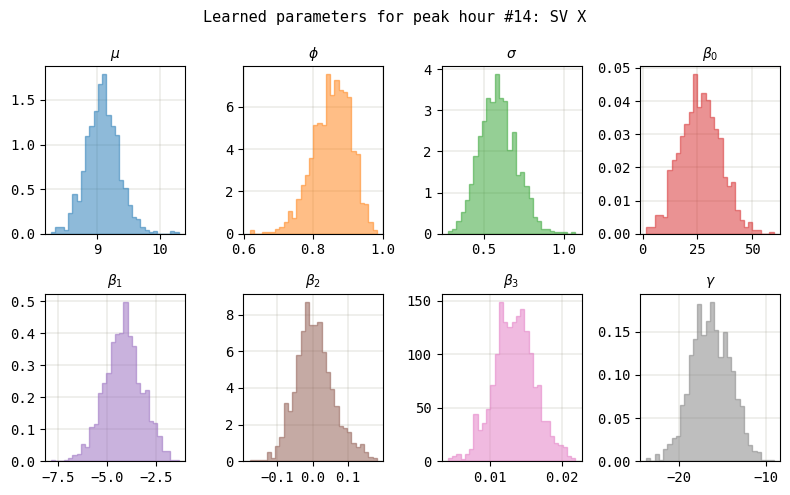

In [58]:
plt.figure(figsize=(8, 5))
ncols = 4
nrows = int(np.ceil(8 / ncols))
for i, param in zip(range(1, 9), fit_sv_x_peak_eur_df[['mu', 'phi', 'sigma', 'beta_0', 'beta_1', 'beta_2', 'beta_3', 'gamma']].describe().columns):
    plt.subplot(nrows, ncols, i)
    plt.hist(fit_sv_x_peak_eur_df[param], bins=30, density=True, histtype='stepfilled', color=f'C{i - 1}', edgecolor=f'C{i - 1}', alpha=0.5)
    plt.xticks(size=10, family='monospace')
    plt.yticks(size=10, family='monospace')
    plt.title(f'$\{param}$', size=10, family='monospace')
    plt.grid(lw=0.25, color='xkcd:cement')
    plt.gca().set_axisbelow(True)
plt.suptitle(f'Learned parameters for peak hour #{hour_max_eur}: {model_sv_x_peak_eur.name}', size=11, family='monospace')
plt.tight_layout();

In [59]:
%%capture
# Predict
predict_sv_x_peak_eur_mean = model_sv_x_peak_eur.predict(price_temp_data_peak_eur[['Temperature', 'Weekday']])
predict_sv_x_peak_eur_mean.shape

In [60]:
%%capture
predict_sv_x_peak_eur_many = model_sv_x_peak_eur.predict_many(price_temp_data_peak_eur[['Temperature', 'Weekday']])
predict_sv_x_peak_eur_many.shape

In [61]:
%%capture
predict_sv_x_peak_eur_ci = model_sv_x_peak_eur.predict_ci(price_temp_data_peak_eur[['Temperature', 'Weekday']], [2.5, 97.5])
len(predict_sv_x_peak_eur_ci)

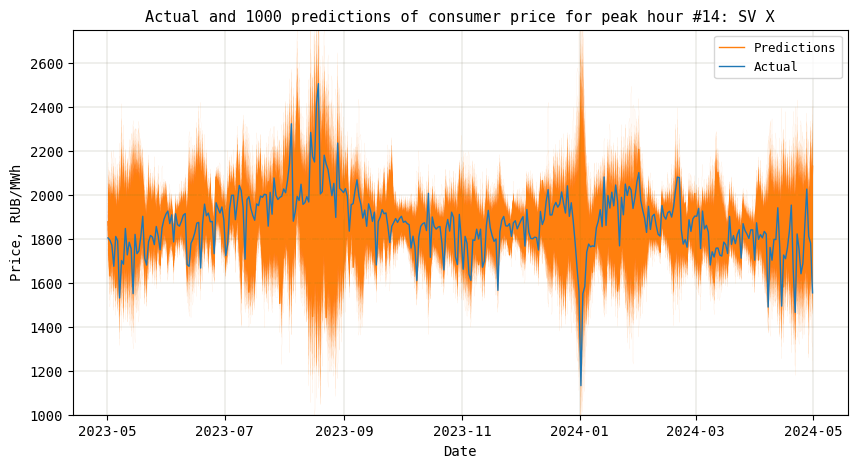

In [62]:
plt.figure(figsize=(10, 5))
plt.plot(price_temp_data_peak_eur.index, predict_sv_x_peak_eur_many.iloc[0], color='C1', lw=1, label='Predictions')
for i in range(1, predict_sv_x_peak_eur_many.shape[0]):
    plt.plot(price_temp_data_peak_eur.index, predict_sv_x_peak_eur_many.iloc[i], color='C1', lw=0.025)
plt.plot(price_temp_data_peak_eur.index, price_temp_data_peak_eur['CONSUMER_PRICE'], color='C0', lw=1, label='Actual')
plt.xlabel('Date', size=10, family='monospace')
plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.ylim([1000, 2750])
plt.title(f'Actual and {num_samples} predictions of consumer price for peak hour #{hour_max_eur}: {model_sv_x_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'});
plt.grid(lw=0.25, color='xkcd:cement');

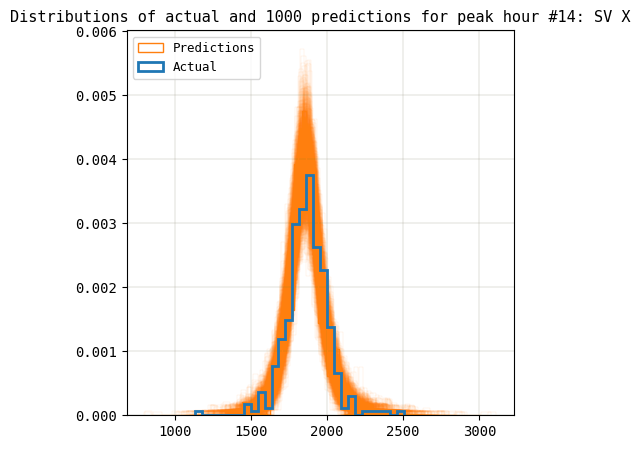

In [63]:
plt.figure(figsize=(5, 5))
plt.hist(predict_sv_x_peak_eur_many.iloc[0], bins=30, density=True, histtype='step', color='white', edgecolor='C1', lw=1, label='Predictions')
for i in range(1, predict_sv_x_peak_eur_many.shape[0]):
    plt.hist(predict_sv_x_peak_eur_many.iloc[i], bins=30, density=True, histtype='step', color='white', edgecolor='C1', lw=0.05)
plt.hist(price_temp_data_peak_eur['CONSUMER_PRICE'], bins=30, density=True, histtype='step', color='white', edgecolor='C0', lw=2, label='Actual')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.grid(lw=0.25, color='xkcd:cement')
plt.legend(loc='upper left', prop={'size': 9, 'family': 'monospace'})
plt.gca().set_axisbelow(True)
plt.title(f'Distributions of actual and {num_samples} predictions for peak hour #{hour_max_eur}: {model_sv_x_peak_eur.name}', size=11, family='monospace');

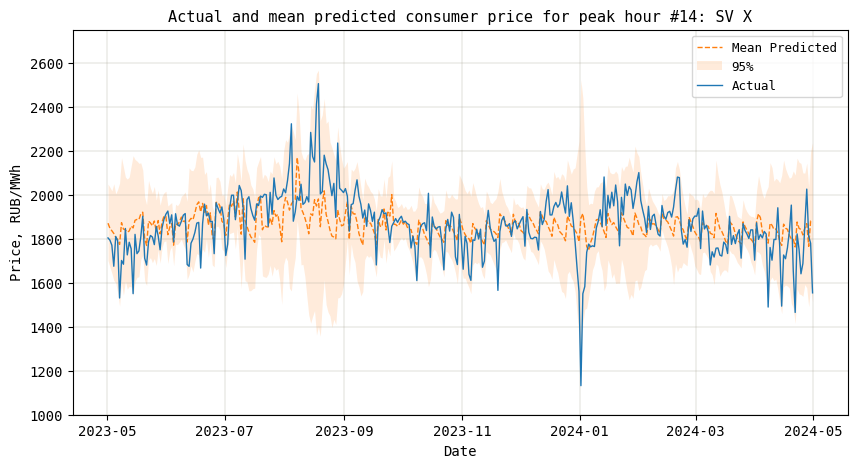

In [64]:
plt.figure(figsize=(10, 5))
plt.plot(price_temp_data_peak_eur.index, predict_sv_x_peak_eur_mean, color='C1', lw=1, ls='--', label='Mean Predicted')
plt.fill_between(price_temp_data_peak_eur.index, predict_sv_x_peak_eur_ci[0], predict_sv_x_peak_eur_ci[1], color='C1', lw=0, alpha=0.15, label='95%')
plt.plot(price_temp_data_peak_eur.index, price_temp_data_peak_eur['CONSUMER_PRICE'], color='C0', lw=1, label='Actual')
plt.xlabel('Date', size=10, family='monospace')
plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.ylim([1000, 2750])
plt.title(f'Actual and mean predicted consumer price for peak hour #{hour_max_eur}: {model_sv_x_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'});
plt.grid(lw=0.25, color='xkcd:cement');

In [65]:
# Volatility at time t over all predictions
vol_sv_x_peak_eur = model_sv_x_peak_eur.get_volatility()
vol_sv_x_peak_eur.shape

(1000, 366)

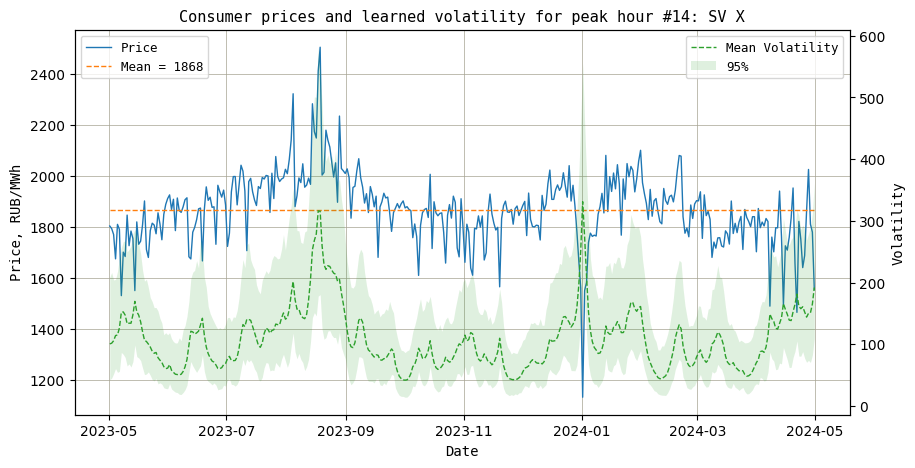

In [66]:
_, ax = plt.subplots(figsize=(10, 5))
ax.plot(price_temp_data_peak_eur.index, price_temp_data_peak_eur['CONSUMER_PRICE'], color='C0', lw=1, label='Price')
ax.hlines(price_temp_data_peak_eur['CONSUMER_PRICE'].mean(), xmin=price_temp_data_peak_eur.index.min(), xmax=price_temp_data_peak_eur.index.max(), color='C1', lw=1, ls='--', label=f"Mean = {price_temp_data_peak_eur['CONSUMER_PRICE'].mean():.0f}")
ax.set_xlabel('Date', size=10, family='monospace')
ax.set_ylabel('Price, RUB/MWh', size=10, family='monospace')
ax.legend(loc='upper left', prop={'size': 9, 'family': 'monospace'})
ax.grid(lw=0.5, color='xkcd:cement')
ax2 = ax.twinx()
ax2.plot(price_temp_data_peak_eur.index, vol_sv_x_peak_eur.mean(axis=0), color='C2', lw=1, ls='--', label='Mean Volatility')
ax2.fill_between(price_temp_data_peak_eur.index, np.percentile(vol_sv_x_peak_eur, [2.5, 97.5], axis=0)[0], np.percentile(vol_sv_x_peak_eur, [2.5, 97.5], axis=0)[1], color='C2', lw=0, alpha=0.15, label='95%')
ax2.set_ylabel('Volatility', size=10, family='monospace')
ax2.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
ax.set_title(f'Consumer prices and learned volatility for peak hour #{hour_max_eur}: {model_sv_x_peak_eur.name}', size=11, family='monospace');

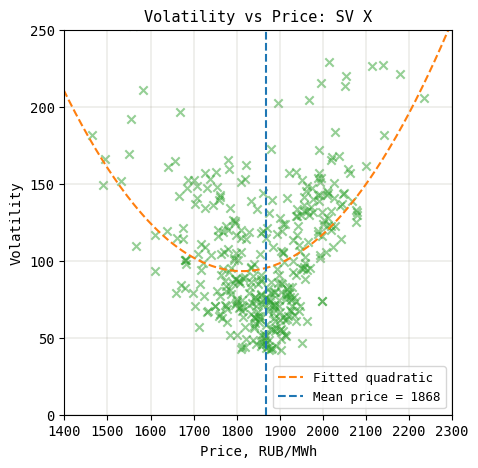

In [67]:
plt.figure(figsize=(5, 5))
fitted_quadratic = np.poly1d(np.polyfit(price_temp_data_peak_eur['CONSUMER_PRICE'], vol_sv_x_peak_eur.mean(axis=0), deg=2))
x = np.linspace(price_temp_data_peak_eur['CONSUMER_PRICE'].min(), price_temp_data_peak_eur['CONSUMER_PRICE'].max(), price_temp_data_peak_eur['CONSUMER_PRICE'].shape[0])
plt.scatter(price_temp_data_peak_eur['CONSUMER_PRICE'], vol_sv_x_peak_eur.mean(axis=0), color='C2', marker='x', alpha=0.5)
plt.plot(x, fitted_quadratic(x), color='C1', ls='--', label='Fitted quadratic')
plt.vlines(price_temp_data_peak_eur['CONSUMER_PRICE'].mean(), ymin=0, ymax=350, color='C0', ls='--', label=f"Mean price = {price_temp_data_peak_eur['CONSUMER_PRICE'].mean():.0f}")
plt.xlabel('Price, RUB/MWh', size=10, family='monospace')
plt.ylabel('Volatility', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.xlim([1400, 2300])
plt.ylim([0, 250])
plt.title(f'Volatility vs Price: {model_sv_x_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='lower right', prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement');

In [68]:
alpha = 0.05
adf_stats, adf_pval, _, _, _, _ = adfuller(vol_sv_x_peak_eur.mean(axis=0))
print(f'{adf_stats = :.2f}, {adf_pval = :.2f}', end=', ')
print('Stationary') if adf_pval < alpha else print('Non-stationary')

adf_stats = -3.87, adf_pval = 0.00, Stationary


As with SV Baseline, we can clearly see that volatility _does_ depend on consumer price, and our **SV X** model discovered this relation.

Again, as with SV Baseline, we can see a rather V-shaped dependency: the volatility tends to increase for the prices higher and lower than the mean price, while it's minimal around the mean price.

##### <a id="eval-sv-x"></a>3.4. Goodness-of-fit

In [69]:
# MAE for mean predictions over all draws
mae_sv_x = mean_absolute_error(price_temp_data_peak_eur['CONSUMER_PRICE'], predict_sv_x_peak_eur_mean)
mae_sv_x

87.55858619633045

In [70]:
# RMSE for mean predictions over all draws
rmse_sv_x = root_mean_squared_error(price_temp_data_peak_eur['CONSUMER_PRICE'], predict_sv_x_peak_eur_mean)
rmse_sv_x

122.4119771174628

Let's check the correlation between mean predicted and actual prices.

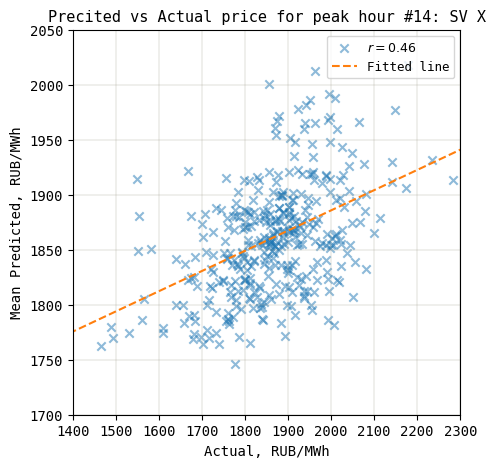

In [71]:
r = np.corrcoef(price_temp_data_peak_eur['CONSUMER_PRICE'], predict_sv_x_peak_eur_mean)[0, 1]
fitted_line = np.poly1d(np.polyfit(price_temp_data_peak_eur['CONSUMER_PRICE'], predict_sv_x_peak_eur_mean, deg=1))
x = np.linspace(price_temp_data_peak_eur['CONSUMER_PRICE'].min(), price_temp_data_peak_eur['CONSUMER_PRICE'].max(), price_temp_data_peak_eur['CONSUMER_PRICE'].shape[0])
plt.figure(figsize=(5, 5))
plt.scatter(price_temp_data_peak_eur['CONSUMER_PRICE'], predict_sv_x_peak_eur_mean, color='C0', marker='x', alpha=0.5, label=f'$r = {r:.2f}$')
plt.plot(x, fitted_line(x), color='C1', ls='--', label='Fitted line')
plt.xlabel('Actual, RUB/MWh', size=10, family='monospace')
plt.ylabel('Mean Predicted, RUB/MWh', size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.xlim([1400, 2300])
plt.ylim([1700, 2050])
plt.title(f'Precited vs Actual price for peak hour #{hour_max_eur}: {model_sv_x_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement');

This time the correlation is stronger, as compared to the SV Baseline model.

We should also check the distribution of residuals, probability plot (similar to Q-Q plot), and residuals vs mean predicted prices.

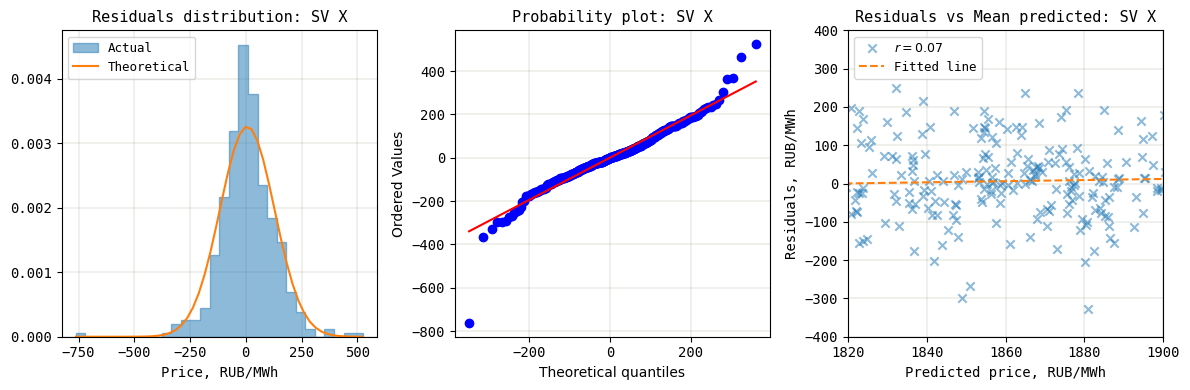

In [72]:
residuals_sv_x = price_data_peak_eur['CONSUMER_PRICE'] - predict_sv_x_peak_eur_mean.values
x = np.linspace(residuals_sv_x.min(), residuals_sv_x.max())
residuals_sv_x_theor = norm(residuals_sv_x.mean(), residuals_sv_x.std(ddof=1))
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(residuals_sv_x, bins=30, density=True, histtype='stepfilled', color='C0', edgecolor='C0', alpha=0.5, label='Actual')
plt.plot(x, residuals_sv_x_theor.pdf(x), color='C1', label='Theoretical')
plt.xlabel('Price, RUB/MWh', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.title(f'Residuals distribution: {model_sv_x_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='upper left', prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement')
plt.gca().set_axisbelow(True)
plt.subplot(1, 3, 2)
probplot(residuals_sv_x, dist=residuals_sv_x_theor, plot=plt)
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.title(f'Probability plot: {model_sv_x_peak_eur.name}', size=11, family='monospace')
plt.grid(lw=0.25, color='xkcd:cement')
plt.gca().set_axisbelow(True)
plt.subplot(1, 3, 3)
r = np.corrcoef(residuals_sv_x, predict_sv_x_peak_eur_mean)[0, 1]
fitted_line = np.poly1d(np.polyfit(predict_sv_x_peak_eur_mean, residuals_sv_x, deg=1))
x = np.linspace(predict_sv_x_peak_eur_mean.min(), predict_sv_x_peak_eur_mean.max(), predict_sv_x_peak_eur_mean.shape[0])
plt.scatter(predict_sv_x_peak_eur_mean, residuals_sv_x, color='C0', marker='x', alpha=0.5, label=f'$r = {r:.2f}$')
plt.plot(x, fitted_line(x), color='C1', ls='--', label='Fitted line')
plt.xlabel('Predicted price, RUB/MWh', size=10, family='monospace')
plt.ylabel('Residuals, RUB/MWh', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(size=10, family='monospace')
plt.xlim([1820, 1900])
plt.ylim([-400, 400])
plt.title(f'Residuals vs Mean predicted: {model_sv_x_peak_eur.name}', size=11, family='monospace')
plt.legend(loc='upper left', prop={'size': 9, 'family': 'monospace'})
plt.grid(lw=0.25, color='xkcd:cement')
plt.gca().set_axisbelow(True)
plt.tight_layout();

Residuals look to be distributed more or less normally. Also they look rather homoscedastic w.r.t. predictions, which means that the model is rather acceptable.

**Overall, the SV X model looks to be a better fit for our price data with the air temperature as an exogenous regressor, as compared to the SV Baseline model.**

[Back](#toc)

---
##### <a id="cross-val"></a>4. Cross-validation

We have trained and tested our models on the same fixed year-long time frame. It is a standard practice to train and test models on different portions of the whole data to generate the distribution of metric(s) and ensure model robustness. This process is known as cross-validation: all data is divided into a number of non-intersecting subsets of samples (folds) some of which are used for training and the rest for testing. For data with i.i.d. samples, i.e. when the samples are independent and thus the order of samples is not important, the order of folds is also not important. This is not the case for time series data, where training folds must not be precede the testing folds, otherwise the target leakage will occur and the model cannot be trusted.

Cross-validation setup.

Models:
1) SV Baseline + Peak hour + Price zone 1 (European)
2) SV Baseline + Peak hour + Price zone 2 (Siberian)
3) SV Baseline + Off-peak hour + Price zone 1
4) SV Baseline + Off-peak hour + Price zone 2
5) SV X + Peak hour + Price zone 1
6) SV X + Peak hour + Price zone 2
7) SV X + Off-peak hour + Price zone 1
8) SV X + Off-peak hour + Price zone 2

Time frame: 23.06.2014 -- 30.04.2024 (3600 days), roughly 10 years.

##### <a id="cross-val-sv-base"></a>4.1. SV Baseline

Load price data for the whole time frame and both price zones.

In [73]:
# # We need to explicitly specify the column names to correctly parse the xml
# price_data = pd.read_xml(f'https://www.atsenergo.ru/market/stats.xml?period=0&date1=20140623&date2=20240430&type=graph',
#                     names=['ROW_ID',
#                             'DAT',
#                             'PRICE_ZONE_CODE',
#                             'CONSUMER_VOLUME',
#                             'CONSUMER_PRICE',
#                             'CONSUMER_RD_VOLUME',
#                             'CONSUMER_SPOT_VOLUME',
#                             'CONSUMER_PROVIDE_RD',
#                             'CONSUMER_MAX_PRICE',
#                             'CONSUMER_MIN_PRICE',
#                             'SUPPLIER_VOLUME',
#                             'SUPPLIER_PRICE',
#                             'SUPPLIER_RD_VOLUME',
#                             'SUPPLIER_SPOT_VOLUME',
#                             'SUPPLIER_PROVIDE_RD',
#                             'SUPPLIER_MAX_PRICE',
#                             'SUPPLIER_MIN_PRICE',
#                             'HOUR'],
#                     xpath='//row',
#                     parse_dates=['DAT'])
# # Make datetime
# price_data = price_data.set_index(pd.to_datetime(price_data['DAT'].astype(str) + 'T' + price_data['HOUR'].astype(str) + ':00:00', dayfirst=True, errors='coerce'))
# price_data.index.name ='Datetime'
# # We can now drop all unnecessary columns to reduce the dataframe
# price_data = price_data.drop(columns=['ROW_ID',
#                         'DAT',
#                         'CONSUMER_VOLUME',
#                         'CONSUMER_RD_VOLUME',
#                         'CONSUMER_SPOT_VOLUME',
#                         'CONSUMER_PROVIDE_RD',
#                         'CONSUMER_MAX_PRICE',
#                         'CONSUMER_MIN_PRICE',
#                         'SUPPLIER_VOLUME',
#                         'SUPPLIER_PRICE',
#                         'SUPPLIER_RD_VOLUME',
#                         'SUPPLIER_SPOT_VOLUME',
#                         'SUPPLIER_PROVIDE_RD',
#                         'SUPPLIER_MAX_PRICE',
#                         'SUPPLIER_MIN_PRICE']).dropna()
# price_data = price_data.loc[~price_data.index.isna()].sort_index()
# price_data['Weekday'] = price_data.index.day_of_week
# price_data.to_csv('./data/price_data_20140623_20240430.csv')

In [136]:
price_data = pd.read_csv('./data/price_data_20140623_20240430.zip', index_col='Datetime', parse_dates=['Datetime'])

In [137]:
price_data.shape

(172800, 4)

In [138]:
price_data.head(4)

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR,Weekday
Datetime,,,,
2014-06-23 00:00:00,1,1147.08,0,0
2014-06-23 00:00:00,2,685.81,0,0
2014-06-23 01:00:00,2,684.27,1,0
2014-06-23 01:00:00,1,1037.39,1,0


In [77]:
price_data.tail(4)

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR,Weekday
Datetime,,,,
2024-04-30 22:00:00,2,1465.38,22,1
2024-04-30 22:00:00,1,1442.53,22,1
2024-04-30 23:00:00,2,1439.88,23,1
2024-04-30 23:00:00,1,1327.94,23,1


In [78]:
price_data.describe()

,PRICE_ZONE_CODE,CONSUMER_PRICE,HOUR,Weekday
count,172800.000000,172800.000000,172800.000000,172800.000000
mean,1.500000,1128.835519,11.500000,2.998611
std,0.500001,311.825787,6.922207,2.000352
min,1.000000,0.000000,0.000000,0.000000
25%,1.000000,901.610000,5.750000,1.000000
50%,1.500000,1061.570000,11.500000,3.000000
75%,2.000000,1355.850000,17.250000,5.000000
max,2.000000,2504.960000,23.000000,6.000000


In [79]:
# Price zone 1 (European)
price_data_eur = price_data[price_data['PRICE_ZONE_CODE'] == 1]
# Price zone 2 (Siberian)
price_data_sib = price_data[price_data['PRICE_ZONE_CODE'] == 2]

In [80]:
# Hour profiles
price_data_daily_agg_eur = price_data_eur.groupby('HOUR')['CONSUMER_PRICE'].mean()
price_data_daily_agg_sib = price_data_sib.groupby('HOUR')['CONSUMER_PRICE'].mean()

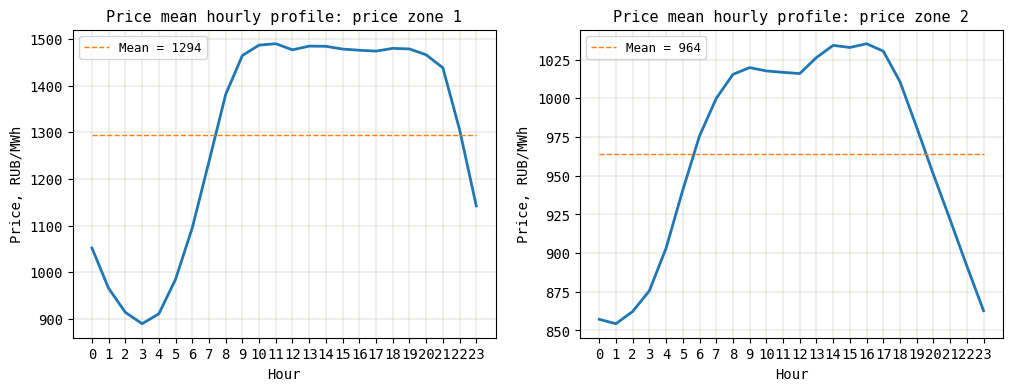

In [81]:
plt.figure(figsize=(12, 4))
for i, hour_profile in zip(range(1, 3), [price_data_daily_agg_eur, price_data_daily_agg_sib]):
    plt.subplot(1, 2, i)
    plt.plot(hour_profile.index, hour_profile, color='C0', lw=2)
    plt.hlines(hour_profile.mean(), xmin=hour_profile.index.min(), xmax=hour_profile.index.max(), color='C1', lw=1, ls='--', label=f"Mean = {hour_profile.mean():.0f}")
    plt.xlabel('Hour', size=10, family='monospace')
    plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
    plt.xticks(hour_profile.index, size=10, family='monospace')
    plt.yticks(size=10, family='monospace')
    plt.title(f'Price mean hourly profile: price zone {i}', size=11, family='monospace')
    plt.legend(prop={'size': 9, 'family': 'monospace'})
    plt.grid(lw=0.25, color='xkcd:cement');

In [82]:
# Peak and off-peak hours
hour_max_eur = price_data_daily_agg_eur.idxmax()
hour_min_eur = price_data_daily_agg_eur.idxmin()
hour_max_sib = price_data_daily_agg_sib.idxmax()
hour_min_sib = price_data_daily_agg_sib.idxmin()
(hour_max_eur, hour_min_eur), (hour_max_sib, hour_min_sib)

((11, 3), (16, 1))

All cross-validation datasets for SV Baseline model.

In [83]:
price_data_peak_eur = price_data_eur[price_data_eur['HOUR'] == hour_max_eur]
price_data_offpeak_eur = price_data_eur[price_data_eur['HOUR'] == hour_min_eur]
price_data_peak_sib = price_data_sib[price_data_sib['HOUR'] == hour_max_sib]
price_data_offpeak_sib = price_data_sib[price_data_sib['HOUR'] == hour_min_sib]

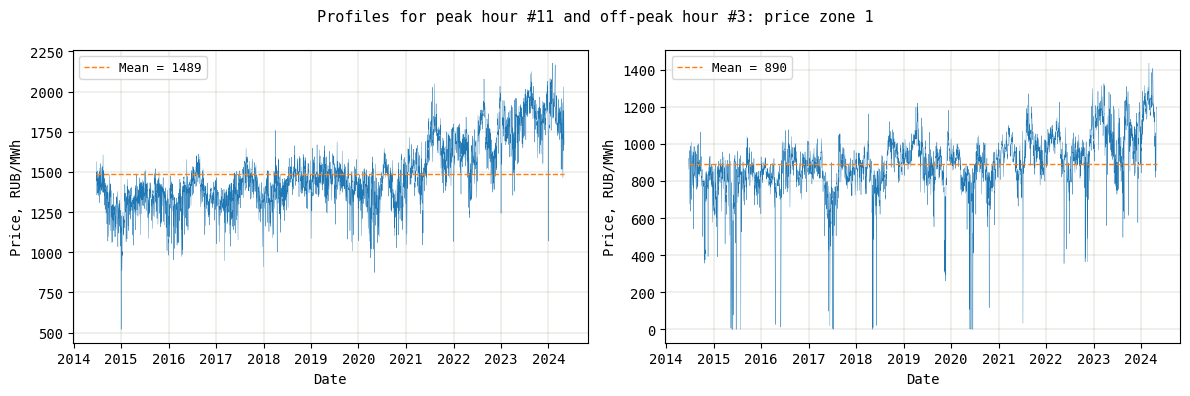

In [84]:
plt.figure(figsize=(12, 4))
for i, hour_profile in zip(range(1, 3), [price_data_peak_eur, price_data_offpeak_eur]):
    plt.subplot(1, 2, i)
    plt.plot(hour_profile.index, hour_profile['CONSUMER_PRICE'], color='C0', lw=0.25)
    plt.hlines(hour_profile['CONSUMER_PRICE'].mean(), xmin=hour_profile.index.min(), xmax=hour_profile.index.max(), color='C1', lw=1, ls='--', label=f"Mean = {hour_profile['CONSUMER_PRICE'].mean():.0f}")
    plt.xlabel('Date', size=10, family='monospace')
    plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
    plt.xticks(size=10, family='monospace')
    plt.yticks(size=10, family='monospace')
    plt.legend(prop={'size': 9, 'family': 'monospace'})
    plt.grid(lw=0.25, color='xkcd:cement');    
    plt.gca().set_axisbelow(True)
plt.suptitle(f'Profiles for peak hour #{hour_max_eur} and off-peak hour #{hour_min_eur}: price zone 1', size=11, family='monospace')
plt.tight_layout();

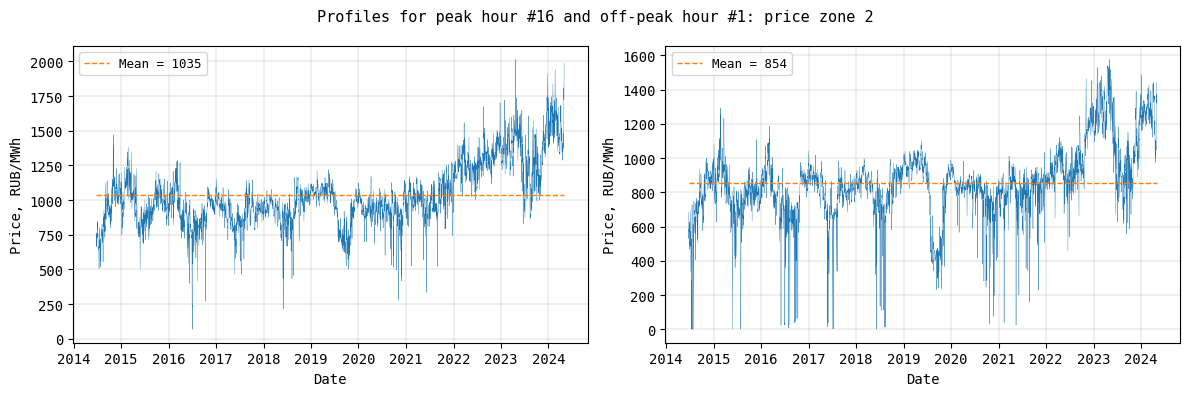

In [85]:
plt.figure(figsize=(12, 4))
for i, hour_profile in zip(range(1, 3), [price_data_peak_sib, price_data_offpeak_sib]):
    plt.subplot(1, 2, i)
    plt.plot(hour_profile.index, hour_profile['CONSUMER_PRICE'], color='C0', lw=0.25)
    plt.hlines(hour_profile['CONSUMER_PRICE'].mean(), xmin=hour_profile.index.min(), xmax=hour_profile.index.max(), color='C1', lw=1, ls='--', label=f"Mean = {hour_profile['CONSUMER_PRICE'].mean():.0f}")
    plt.xlabel('Date', size=10, family='monospace')
    plt.ylabel('Price, RUB/MWh', size=10, family='monospace')
    plt.xticks(size=10, family='monospace')
    plt.yticks(size=10, family='monospace')
    plt.legend(loc='upper left', prop={'size': 9, 'family': 'monospace'})
    plt.grid(lw=0.25, color='xkcd:cement');    
    plt.gca().set_axisbelow(True)
plt.suptitle(f'Profiles for peak hour #{hour_max_sib} and off-peak hour #{hour_min_sib}: price zone 2', size=11, family='monospace')
plt.tight_layout();

All SV Baseline models to cross-validate.

In [86]:
with open('./models/sv_base_fit.stan', 'r') as fh:
  sv_base_code_fit = fh.read()
with open('./models/sv_base_predict.stan', 'r') as fh:
  sv_base_code_predict = fh.read()
num_samples = 1_000

In [87]:
# 1) SV Baseline + Peak hour + Price zone 1
model_sv_base_peak_eur = StanModel(kind='sv_base',
                                  name='SV Baseline + Peak hour + Price zone 1',
                                  stan_code_fit=sv_base_code_fit,
                                  stan_code_predict=sv_base_code_predict, 
                                  num_samples=num_samples)

In [88]:
# 2) SV Baseline + Peak hour + Price zone 2
model_sv_base_peak_sib = StanModel(kind='sv_base',
                                  name='SV Baseline + Peak hour + Price zone 2',
                                  stan_code_fit=sv_base_code_fit,
                                  stan_code_predict=sv_base_code_predict, 
                                  num_samples=num_samples)

In [89]:
# 3) SV Baseline + Off-peak hour + Price zone 1
model_sv_base_offpeak_eur = StanModel(kind='sv_base',
                                  name='SV Baseline + Off-peak hour + Price zone 1',
                                  stan_code_fit=sv_base_code_fit,
                                  stan_code_predict=sv_base_code_predict, 
                                  num_samples=num_samples)

In [90]:
# 4) SV Baseline + Off-peak hour + Price zone 2
model_sv_base_offpeak_sib = StanModel(kind='sv_base',
                                  name='SV Baseline + Off-peak hour + Price zone 2',
                                  stan_code_fit=sv_base_code_fit,
                                  stan_code_predict=sv_base_code_predict, 
                                  num_samples=num_samples)

Cross-validation strategy:
1) Choose some starting date;
2) Train for 360 days (approx. 1 year) from starting date;
3) Predict 90 days (approx. 3 months = 1 quarter) ahead using the most recent log volatility obtained during training;
4) Move the date sliding window repeat from 2.

The number of date sliding windows $\displaystyle N_{w} = \frac{3600 - 30 \times 12}{30 \times 3} = 36$.

Let's use scikit-learn's Time Series cross-validator to correctly split our consumer price (SV Baseline / SV X) and air temperature (SV X) data into train and test subsets.

In [91]:
n_windows = 36 # Number of sliding windows
ts_cv_sv_base = TimeSeriesSplit(n_splits=n_windows, max_train_size=30*12, test_size=30*3, gap=0)

In [92]:
print('Split # | Train fold                     | Test fold')
print('--------|--------------------------------|------------------------------')
# All 4 subsets have equal size, so get split indices from any of the four
for i, split in enumerate(ts_cv_sv_base.split(price_data_peak_eur)):
    train_start = price_data_peak_eur.iloc[split[0]].index.min().date()
    train_end = price_data_peak_eur.iloc[split[0]].index.max().date()
    test_start = price_data_peak_eur.iloc[split[1]].index.min().date()
    test_end = price_data_peak_eur.iloc[split[1]].index.max().date()
    print(f'{i + 1:>7} | {train_start} -- {train_end} ({(train_end - train_start).days + 1}) | {test_start} -- {test_end} ({(test_end - test_start).days + 1})')

Split # | Train fold                     | Test fold
--------|--------------------------------|------------------------------
      1 | 2014-06-23 -- 2015-06-17 (360) | 2015-06-18 -- 2015-09-15 (90)
      2 | 2014-09-21 -- 2015-09-15 (360) | 2015-09-16 -- 2015-12-14 (90)
      3 | 2014-12-20 -- 2015-12-14 (360) | 2015-12-15 -- 2016-03-13 (90)
      4 | 2015-03-20 -- 2016-03-13 (360) | 2016-03-14 -- 2016-06-11 (90)
      5 | 2015-06-18 -- 2016-06-11 (360) | 2016-06-12 -- 2016-09-09 (90)
      6 | 2015-09-16 -- 2016-09-09 (360) | 2016-09-10 -- 2016-12-08 (90)
      7 | 2015-12-15 -- 2016-12-08 (360) | 2016-12-09 -- 2017-03-08 (90)
      8 | 2016-03-14 -- 2017-03-08 (360) | 2017-03-09 -- 2017-06-06 (90)
      9 | 2016-06-12 -- 2017-06-06 (360) | 2017-06-07 -- 2017-09-04 (90)
     10 | 2016-09-10 -- 2017-09-04 (360) | 2017-09-05 -- 2017-12-03 (90)
     11 | 2016-12-09 -- 2017-12-03 (360) | 2017-12-04 -- 2018-03-03 (90)
     12 | 2017-03-09 -- 2018-03-03 (360) | 2018-03-04 -- 2018-06-01 (90

In [93]:
#price_data_peak_eur.iloc[all_splits[0][0]]

In [ ]:
%%capture
models = [model_sv_base_peak_eur, model_sv_base_peak_sib, model_sv_base_offpeak_eur, model_sv_base_offpeak_sib]
subsets = [price_data_peak_eur, price_data_peak_sib, price_data_offpeak_eur, price_data_offpeak_sib]
cv_results_sv_base_df = pd.DataFrame(columns=['model_kind', 'model_name', 'train_indices', 'test_indices', 'fit_time', 'score_time', 'test_mae', 'test_rmse'])
print('Running cross-validation...')
for model, subset in tqdm(zip(models, subsets)):
    print(f'Model: {model.name}')
    cv_result = cross_validate(model,
                                X=subset['CONSUMER_PRICE'],
                                y=subset['CONSUMER_PRICE'],
                                cv=ts_cv_sv_base,
                                scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'],
                                return_indices=True,
                                n_jobs=4)
    cv_result_df = pd.concat([pd.Series(cv_result['indices']['train'], name='train_indices'),
    pd.Series(cv_result['indices']['test'], name='test_indices'),
    pd.Series(cv_result['fit_time'], name='fit_time'), 
    pd.Series(cv_result['score_time'], name='score_time'), 
    pd.Series(-cv_result['test_neg_mean_absolute_error'], name='test_mae'), 
    pd.Series(-cv_result['test_neg_root_mean_squared_error'], name='test_rmse')], axis=1)
    cv_results_sv_base_df = pd.concat([cv_results_sv_base_df, pd.concat([pd.Series([model.kind] * n_windows, name='model_kind'), pd.Series([model.name] * n_windows, name='model_name'), cv_result_df], axis=1)])
cv_results_sv_base_df = cv_results_sv_base_df.reset_index(drop=True)
print('Done!')

In [95]:
cv_results_sv_base_df

,model_kind,model_name,train_indices,test_indices,fit_time,score_time,test_mae,test_rmse
0,sv_base,SV Baseline + Peak hour + Price zone 1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[360, 361, 362, 363, 364, 365, 366, 367, 368, ...",0.752721,0.304482,66.932230,82.187065
1,sv_base,SV Baseline + Peak hour + Price zone 1,"[90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...","[450, 451, 452, 453, 454, 455, 456, 457, 458, ...",0.860404,0.352663,91.498069,102.352921
2,sv_base,SV Baseline + Peak hour + Price zone 1,"[180, 181, 182, 183, 184, 185, 186, 187, 188, ...","[540, 541, 542, 543, 544, 545, 546, 547, 548, ...",11.027058,0.241492,98.059416,131.124286
3,sv_base,SV Baseline + Peak hour + Price zone 1,"[270, 271, 272, 273, 274, 275, 276, 277, 278, ...","[630, 631, 632, 633, 634, 635, 636, 637, 638, ...",0.870622,0.352363,90.657318,116.004756
4,sv_base,SV Baseline + Peak hour + Price zone 1,"[360, 361, 362, 363, 364, 365, 366, 367, 368, ...","[720, 721, 722, 723, 724, 725, 726, 727, 728, ...",6.084482,0.219657,144.874059,158.346917
...,...,...,...,...,...,...,...,...
139,sv_base,SV Baseline + Off-peak hour + Price zone 2,"[2790, 2791, 2792, 2793, 2794, 2795, 2796, 279...","[3150, 3151, 3152, 3153, 3154, 3155, 3156, 315...",11.669283,0.210473,303.764088,326.017876
140,sv_base,SV Baseline + Off-peak hour + Price zone 2,"[2880, 2881, 2882, 2883, 2884, 2885, 2886, 288...","[3240, 3241, 3242, 3243, 3244, 3245, 3246, 324...",0.677500,0.263237,175.065520,206.851707
141,sv_base,SV Baseline + Off-peak hour + Price zone 2,"[2970, 2971, 2972, 2973, 2974, 2975, 2976, 297...","[3330, 3331, 3332, 3333, 3334, 3335, 3336, 333...",8.867275,0.184052,261.340821,287.419361
142,sv_base,SV Baseline + Off-peak hour + Price zone 2,"[3060, 3061, 3062, 3063, 3064, 3065, 3066, 306...","[3420, 3421, 3422, 3423, 3424, 3425, 3426, 342...",0.868750,0.211079,121.891326,137.366055


In [96]:
# Mean MAE by model
mae_sv_base_cross = cv_results_sv_base_df.groupby('model_name')['test_mae']
mae_sv_base_cross.mean().sort_values()

model_name
SV Baseline + Off-peak hour + Price zone 1    104.422811
SV Baseline + Peak hour + Price zone 1        105.385055
SV Baseline + Peak hour + Price zone 2        119.140971
SV Baseline + Off-peak hour + Price zone 2    134.863451
Name: test_mae, dtype: float64

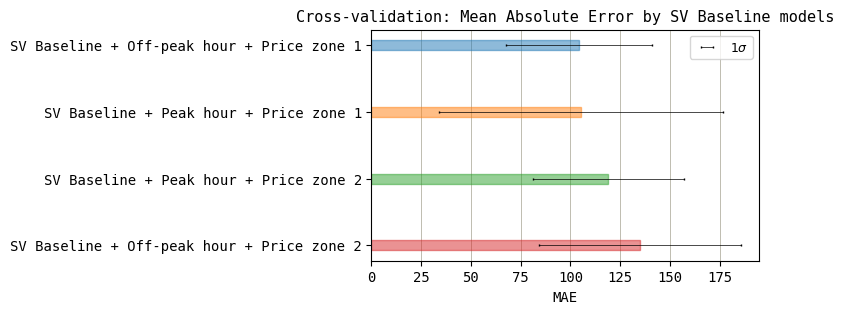

In [97]:
plt.figure(figsize=(5, 3))
bars = plt.barh(range(mae_sv_base_cross.mean().shape[0]), mae_sv_base_cross.mean().sort_values(), xerr=mae_sv_base_cross.std(ddof=1), height=0.15, align='center', alpha=0.5, error_kw={'lw': 0.5, 'capsize': 1, 'label': '$1\sigma$'})
plt.gca().invert_yaxis()
plt.xlabel('MAE', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(range(mae_sv_base_cross.mean().shape[0]), mae_sv_base_cross.mean().sort_values().index, size=10, family='monospace')
plt.grid(axis='x', lw=0.5, color='xkcd:cement')
for i in range(len(bars)):
    bars[i].set_edgecolor(f'C{i}')
    bars[i].set_color(f'C{i}')
plt.gca().set_axisbelow(True)
plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
plt.title('Cross-validation: Mean Absolute Error by SV Baseline models', size=11, family='monospace');

In [98]:
# Mean RMSE by model
rmse_sv_base_cross = cv_results_sv_base_df.groupby('model_name')['test_rmse']
rmse_sv_base_cross.mean().sort_values()

model_name
SV Baseline + Peak hour + Price zone 1        130.526412
SV Baseline + Off-peak hour + Price zone 1    137.501447
SV Baseline + Peak hour + Price zone 2        146.445320
SV Baseline + Off-peak hour + Price zone 2    168.305299
Name: test_rmse, dtype: float64

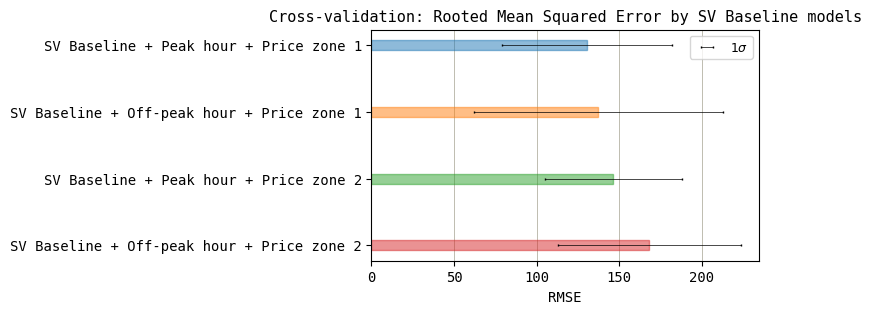

In [99]:
plt.figure(figsize=(5, 3))
bars = plt.barh(range(rmse_sv_base_cross.mean().shape[0]), rmse_sv_base_cross.mean().sort_values(), xerr=rmse_sv_base_cross.std(ddof=1), height=0.15, align='center', alpha=0.5, error_kw={'lw': 0.5, 'capsize': 1, 'label': '$1\sigma$'})
plt.gca().invert_yaxis()
plt.xlabel('RMSE', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(range(rmse_sv_base_cross.mean().shape[0]), rmse_sv_base_cross.mean().sort_values().index, size=10, family='monospace')
plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
plt.grid(axis='x', lw=0.5, color='xkcd:cement')
for i in range(len(bars)):
    bars[i].set_edgecolor(f'C{i}')
    bars[i].set_color(f'C{i}')
plt.gca().set_axisbelow(True)
plt.title('Cross-validation: Rooted Mean Squared Error by SV Baseline models', size=11, family='monospace');

Both metrics show that on average:
- SV Baseline models for Price zone 1 (European) have higher quality than for Price zone 2 (Siberian);
- the best model is for Price zone 1 for Peak hour;
- the worst model is for Price zone 2 for Off-peak hour.

##### <a id="cross-val-sv-x"></a>4.2. SV X

Load air temperature data for the whole time frame and both price zones.

In [139]:
# Price zone 1: Moscow
temp_data_eur = pd.read_csv(f'./data/UUEE.23.06.2014.30.04.2024.1.0.0.ru.utf8.00000000.zip', 
                        sep=';', 
                        encoding='utf-8',
                        skiprows=7, 
                        index_col=0, 
                        dayfirst=True, 
                        usecols=[0, 1], 
                        names=['Datetime', 'Temperature'], 
                        parse_dates=True).dropna().sort_index()

In [140]:
temp_data_eur

,Temperature
Datetime,
2014-06-23 00:00:00,8.0
2014-06-23 00:30:00,9.0
2014-06-23 01:00:00,8.0
2014-06-23 01:30:00,10.0
2014-06-23 02:00:00,12.0
...,...
2024-04-30 21:30:00,18.0
2024-04-30 22:00:00,19.0
2024-04-30 22:30:00,19.0


In [141]:
# Price zone 2: Novosibirsk
temp_data_sib = pd.read_csv(f'./data/UNNT.23.06.2014.30.04.2024.1.0.0.ru.utf8.00000000.zip', 
                        sep=';', 
                        encoding='utf-8',
                        skiprows=7, 
                        index_col=0, 
                        dayfirst=True, 
                        usecols=[0, 1], 
                        names=['Datetime', 'Temperature'], 
                        parse_dates=True).dropna().sort_index()
# Don't forget to convert local Novosibirsk time to Moscow time, since all price data is in Moscow time
temp_data_sib.index = temp_data_sib.index - pd.Timedelta(hours=4)

In [142]:
temp_data_sib

,Temperature
Datetime,
2014-06-22 20:00:00,21.0
2014-06-22 20:30:00,20.0
2014-06-22 21:00:00,19.0
2014-06-22 21:30:00,18.0
2014-06-22 22:00:00,17.0
...,...
2024-04-30 17:30:00,3.0
2024-04-30 18:00:00,2.0
2024-04-30 18:30:00,1.0


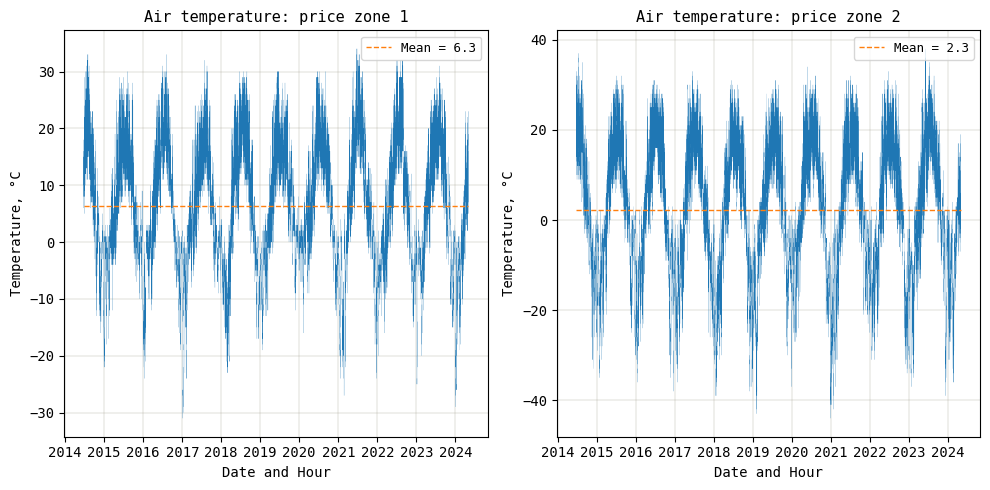

In [104]:
plt.figure(figsize=(10, 5))
for i, temp_history in zip(range(1, 3), [temp_data_eur, temp_data_sib]):
    plt.subplot(1, 2, i)
    plt.plot(temp_history.index, temp_history['Temperature'], color='C0', lw=0.1)
    plt.hlines(temp_history['Temperature'].mean(), xmin=temp_history.index.min(), xmax=temp_history.index.max(), color='C1', lw=1, ls='--', label=f"Mean = {temp_history['Temperature'].mean():.1f}")
    plt.xlabel('Date and Hour', size=10, family='monospace')
    plt.ylabel('Temperature, °C', size=10, family='monospace')
    plt.xticks(size=10, family='monospace')
    plt.yticks(size=10, family='monospace')
    plt.title(f'Air temperature: price zone {i}', size=11, family='monospace')
    plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
    plt.grid(lw=0.25, color='xkcd:cement')
plt.tight_layout();

In [105]:
# Join consumer price and air temperature data
price_temp_data_peak_eur = pd.merge(price_data_peak_eur, temp_data_eur, on='Datetime')
price_temp_data_offpeak_eur = pd.merge(price_data_offpeak_eur, temp_data_eur, on='Datetime')
price_temp_data_peak_sib = pd.merge(price_data_peak_sib, temp_data_sib, on='Datetime')
price_temp_data_offpeak_sib = pd.merge(price_data_offpeak_sib, temp_data_sib, on='Datetime')

All SV X models to cross-validate.

In [106]:
with open('./models/sv_x_fit.stan', 'r') as fh:
  sv_x_code_fit = fh.read()
with open('./models/sv_x_predict.stan', 'r') as fh:
  sv_x_code_predict = fh.read()
num_samples = 1_000

In [107]:
# 5) SV X + Peak hour + Price zone 1
model_sv_x_peak_eur = StanModel(kind='sv_x',
                                  name='SV X + Peak hour + Price zone 1',
                                  stan_code_fit=sv_x_code_fit,
                                  stan_code_predict=sv_x_code_predict, 
                                  num_samples=num_samples)

In [108]:
# 6) SV X + Peak hour + Price zone 2
model_sv_x_peak_sib = StanModel(kind='sv_x',
                                  name='SV X + Peak hour + Price zone 2',
                                  stan_code_fit=sv_x_code_fit,
                                  stan_code_predict=sv_x_code_predict, 
                                  num_samples=num_samples)

In [109]:
# 7) SV X + Off-peak hour + Price zone 1
model_sv_x_offpeak_eur = StanModel(kind='sv_x',
                                  name='SV X + Off-peak hour + Price zone 1',
                                  stan_code_fit=sv_x_code_fit,
                                  stan_code_predict=sv_x_code_predict, 
                                  num_samples=num_samples)

In [110]:
# 8) SV X + Off-peak hour + Price zone 2
model_sv_x_offpeak_sib = StanModel(kind='sv_x',
                                  name='SV X + Off-peak hour + Price zone 2',
                                  stan_code_fit=sv_x_code_fit,
                                  stan_code_predict=sv_x_code_predict, 
                                  num_samples=num_samples)

In [111]:
n_windows = 36 # Number of sliding windows
ts_cv_sv_x = TimeSeriesSplit(n_splits=n_windows, max_train_size=30*12, test_size=30*3, gap=0)

In [112]:
print('Split # | Train fold                     | Test fold')
print('--------|--------------------------------|------------------------------')
# Due to air temperature having missing data, the 4 subsets are not strictly equal, but anyway have around 3600 days each
# So get split indices from any of the four
for i, split in enumerate(ts_cv_sv_x.split(price_temp_data_peak_eur)):
    train_start = price_temp_data_peak_eur.iloc[split[0]].index.min().date()
    train_end = price_temp_data_peak_eur.iloc[split[0]].index.max().date()
    test_start = price_temp_data_peak_eur.iloc[split[1]].index.min().date()
    test_end = price_temp_data_peak_eur.iloc[split[1]].index.max().date()
    print(f'{i + 1:>7} | {train_start} -- {train_end} ({(train_end - train_start).days + 1}) | {test_start} -- {test_end} ({(test_end - test_start).days + 1})')

Split # | Train fold                     | Test fold
--------|--------------------------------|------------------------------
      1 | 2014-06-23 -- 2015-06-09 (352) | 2015-06-10 -- 2015-09-10 (93)
      2 | 2014-09-13 -- 2015-09-10 (363) | 2015-09-11 -- 2015-12-10 (91)
      3 | 2014-12-12 -- 2015-12-10 (364) | 2015-12-11 -- 2016-03-09 (90)
      4 | 2015-03-12 -- 2016-03-09 (364) | 2016-03-10 -- 2016-06-08 (91)
      5 | 2015-06-10 -- 2016-06-08 (365) | 2016-06-09 -- 2016-09-07 (91)
      6 | 2015-09-11 -- 2016-09-07 (363) | 2016-09-08 -- 2016-12-06 (90)
      7 | 2015-12-11 -- 2016-12-06 (362) | 2016-12-07 -- 2017-03-06 (90)
      8 | 2016-03-10 -- 2017-03-06 (362) | 2017-03-07 -- 2017-06-04 (90)
      9 | 2016-06-09 -- 2017-06-04 (361) | 2017-06-06 -- 2017-09-03 (90)
     10 | 2016-09-08 -- 2017-09-03 (361) | 2017-09-04 -- 2017-12-02 (90)
     11 | 2016-12-07 -- 2017-12-02 (361) | 2017-12-03 -- 2018-03-02 (90)
     12 | 2017-03-07 -- 2018-03-02 (361) | 2018-03-03 -- 2018-05-31 (90

In [ ]:
%%capture
models = [model_sv_x_peak_eur, model_sv_x_peak_sib, model_sv_x_offpeak_eur, model_sv_x_offpeak_sib]
subsets = [price_temp_data_peak_eur, price_temp_data_peak_sib, price_temp_data_offpeak_eur, price_temp_data_offpeak_sib]
cv_results_sv_x_df = pd.DataFrame(columns=['model_kind', 'model_name', 'train_indices', 'test_indices', 'fit_time', 'score_time', 'test_mae', 'test_rmse'])
print('Running cross-validation...')
for model, subset in tqdm(zip(models, subsets)):
    print(f'Model: {model.name}')
    cv_result = cross_validate(model,
                                X=subset[['Temperature', 'Weekday']],
                                y=subset['CONSUMER_PRICE'],
                                cv=ts_cv_sv_x,
                                scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'],
                                return_indices=True,
                                n_jobs=4)
    cv_result_df = pd.concat([pd.Series(cv_result['indices']['train'], name='train_indices'),
    pd.Series(cv_result['indices']['test'], name='test_indices'),
    pd.Series(cv_result['fit_time'], name='fit_time'), 
    pd.Series(cv_result['score_time'], name='score_time'), 
    pd.Series(-cv_result['test_neg_mean_absolute_error'], name='test_mae'), 
    pd.Series(-cv_result['test_neg_root_mean_squared_error'], name='test_rmse')], axis=1)
    cv_results_sv_x_df = pd.concat([cv_results_sv_x_df, pd.concat([pd.Series([model.kind] * n_windows, name='model_kind'), pd.Series([model.name] * n_windows, name='model_name'), cv_result_df], axis=1)])
cv_results_sv_x_df = cv_results_sv_x_df.reset_index(drop=True)
print('Done!')

In [114]:
cv_results_sv_x_df

,model_kind,model_name,train_indices,test_indices,fit_time,score_time,test_mae,test_rmse
0,sv_x,SV X + Peak hour + Price zone 1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[352, 353, 354, 355, 356, 357, 358, 359, 360, ...",44.250323,0.218133,56.855627,78.000257
1,sv_x,SV X + Peak hour + Price zone 1,"[82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 9...","[442, 443, 444, 445, 446, 447, 448, 449, 450, ...",37.492487,0.242368,81.560276,91.750638
2,sv_x,SV X + Peak hour + Price zone 1,"[172, 173, 174, 175, 176, 177, 178, 179, 180, ...","[532, 533, 534, 535, 536, 537, 538, 539, 540, ...",41.617261,0.207746,100.351677,132.101229
3,sv_x,SV X + Peak hour + Price zone 1,"[262, 263, 264, 265, 266, 267, 268, 269, 270, ...","[622, 623, 624, 625, 626, 627, 628, 629, 630, ...",37.767862,0.224910,82.659408,114.198728
4,sv_x,SV X + Peak hour + Price zone 1,"[352, 353, 354, 355, 356, 357, 358, 359, 360, ...","[712, 713, 714, 715, 716, 717, 718, 719, 720, ...",36.321418,0.240181,100.928047,117.787923
...,...,...,...,...,...,...,...,...
139,sv_x,SV X + Off-peak hour + Price zone 2,"[2760, 2761, 2762, 2763, 2764, 2765, 2766, 276...","[3120, 3121, 3122, 3123, 3124, 3125, 3126, 312...",31.303796,0.218908,231.638691,276.624378
140,sv_x,SV X + Off-peak hour + Price zone 2,"[2850, 2851, 2852, 2853, 2854, 2855, 2856, 285...","[3210, 3211, 3212, 3213, 3214, 3215, 3216, 321...",35.100188,0.219992,184.306026,229.356669
141,sv_x,SV X + Off-peak hour + Price zone 2,"[2940, 2941, 2942, 2943, 2944, 2945, 2946, 294...","[3300, 3301, 3302, 3303, 3304, 3305, 3306, 330...",35.152798,0.209809,164.655720,203.808256
142,sv_x,SV X + Off-peak hour + Price zone 2,"[3030, 3031, 3032, 3033, 3034, 3035, 3036, 303...","[3390, 3391, 3392, 3393, 3394, 3395, 3396, 339...",38.233119,0.190804,103.087148,125.390091


In [115]:
# Mean MAE by model
mae_sv_x_cross = cv_results_sv_x_df.groupby('model_name')['test_mae']
mae_sv_x_cross.mean().sort_values()

model_name
SV X + Off-peak hour + Price zone 1     98.085944
SV X + Peak hour + Price zone 1        101.093663
SV X + Peak hour + Price zone 2        115.857868
SV X + Off-peak hour + Price zone 2    121.031701
Name: test_mae, dtype: float64

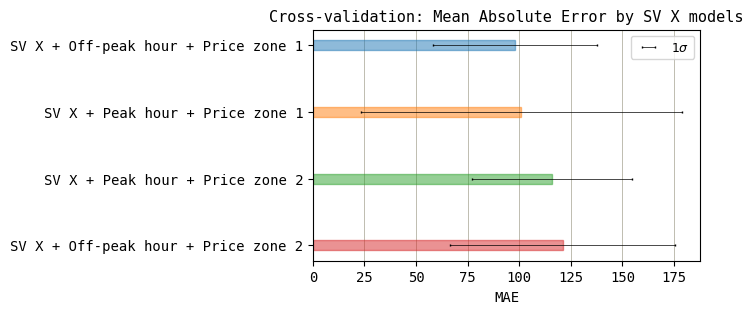

In [116]:
plt.figure(figsize=(5, 3))
bars = plt.barh(range(mae_sv_x_cross.mean().shape[0]), mae_sv_x_cross.mean().sort_values(), xerr=mae_sv_x_cross.std(ddof=1), height=0.15, align='center', alpha=0.5, error_kw={'lw': 0.5, 'capsize': 1, 'label': '$1\sigma$'})
plt.gca().invert_yaxis()
plt.xlabel('MAE', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(range(mae_sv_x_cross.mean().shape[0]), mae_sv_x_cross.mean().sort_values().index, size=10, family='monospace')
plt.grid(axis='x', lw=0.5, color='xkcd:cement')
for i in range(len(bars)):
    bars[i].set_edgecolor(f'C{i}')
    bars[i].set_color(f'C{i}')
plt.gca().set_axisbelow(True)
plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
plt.title('Cross-validation: Mean Absolute Error by SV X models', size=11, family='monospace');

In [117]:
# Mean RMSE by model
rmse_sv_x_cross = cv_results_sv_x_df.groupby('model_name')['test_rmse']
rmse_sv_x_cross.mean().sort_values()

model_name
SV X + Peak hour + Price zone 1        125.732587
SV X + Off-peak hour + Price zone 1    133.830062
SV X + Peak hour + Price zone 2        143.087490
SV X + Off-peak hour + Price zone 2    155.041461
Name: test_rmse, dtype: float64

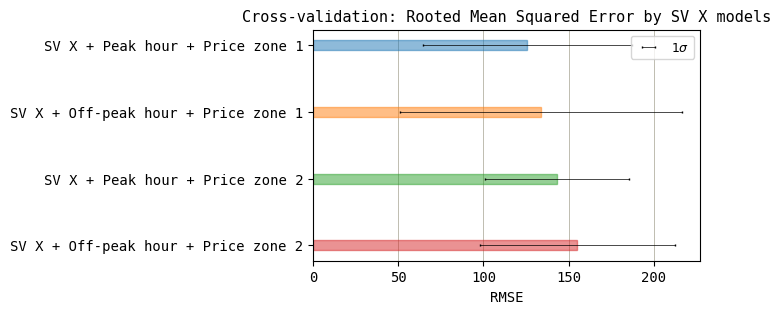

In [118]:
plt.figure(figsize=(5, 3))
bars = plt.barh(range(rmse_sv_x_cross.mean().shape[0]), rmse_sv_x_cross.mean().sort_values(), xerr=rmse_sv_x_cross.std(ddof=1), height=0.15, align='center', alpha=0.5, error_kw={'lw': 0.5, 'capsize': 1, 'label': '$1\sigma$'})
plt.gca().invert_yaxis()
plt.xlabel('RMSE', size=10, family='monospace')
plt.xticks(size=10, family='monospace')
plt.yticks(range(rmse_sv_x_cross.mean().shape[0]), rmse_sv_x_cross.mean().sort_values().index, size=10, family='monospace')
plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
plt.grid(axis='x', lw=0.5, color='xkcd:cement')
for i in range(len(bars)):
    bars[i].set_edgecolor(f'C{i}')
    bars[i].set_color(f'C{i}')
plt.gca().set_axisbelow(True)
plt.title('Cross-validation: Rooted Mean Squared Error by SV X models', size=11, family='monospace');

As with SV Baseline model, both metrics for SV X model show that on average:
- models for Price zone 1 (European) have higher quality than for Price zone 2 (Siberian);
- the best model is for Price zone 1 for Peak hour;
- the worst model is for Price zone 2 for Off-peak hour.

##### <a id="cross-val-comparison"></a>4.3. Model Comparison

Let's compare the distributions of MAE and RMSE metrics obtained during cross-validation.

In [119]:
cv_results_sv_all_df = pd.concat([cv_results_sv_base_df, cv_results_sv_x_df], axis=0)
cv_results_sv_all_df

,model_kind,model_name,train_indices,test_indices,fit_time,score_time,test_mae,test_rmse
0,sv_base,SV Baseline + Peak hour + Price zone 1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[360, 361, 362, 363, 364, 365, 366, 367, 368, ...",0.752721,0.304482,66.932230,82.187065
1,sv_base,SV Baseline + Peak hour + Price zone 1,"[90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...","[450, 451, 452, 453, 454, 455, 456, 457, 458, ...",0.860404,0.352663,91.498069,102.352921
2,sv_base,SV Baseline + Peak hour + Price zone 1,"[180, 181, 182, 183, 184, 185, 186, 187, 188, ...","[540, 541, 542, 543, 544, 545, 546, 547, 548, ...",11.027058,0.241492,98.059416,131.124286
3,sv_base,SV Baseline + Peak hour + Price zone 1,"[270, 271, 272, 273, 274, 275, 276, 277, 278, ...","[630, 631, 632, 633, 634, 635, 636, 637, 638, ...",0.870622,0.352363,90.657318,116.004756
4,sv_base,SV Baseline + Peak hour + Price zone 1,"[360, 361, 362, 363, 364, 365, 366, 367, 368, ...","[720, 721, 722, 723, 724, 725, 726, 727, 728, ...",6.084482,0.219657,144.874059,158.346917
...,...,...,...,...,...,...,...,...
139,sv_x,SV X + Off-peak hour + Price zone 2,"[2760, 2761, 2762, 2763, 2764, 2765, 2766, 276...","[3120, 3121, 3122, 3123, 3124, 3125, 3126, 312...",31.303796,0.218908,231.638691,276.624378
140,sv_x,SV X + Off-peak hour + Price zone 2,"[2850, 2851, 2852, 2853, 2854, 2855, 2856, 285...","[3210, 3211, 3212, 3213, 3214, 3215, 3216, 321...",35.100188,0.219992,184.306026,229.356669
141,sv_x,SV X + Off-peak hour + Price zone 2,"[2940, 2941, 2942, 2943, 2944, 2945, 2946, 294...","[3300, 3301, 3302, 3303, 3304, 3305, 3306, 330...",35.152798,0.209809,164.655720,203.808256
142,sv_x,SV X + Off-peak hour + Price zone 2,"[3030, 3031, 3032, 3033, 3034, 3035, 3036, 303...","[3390, 3391, 3392, 3393, 3394, 3395, 3396, 339...",38.233119,0.190804,103.087148,125.390091


In [120]:
cv_results_peak_eur = cv_results_sv_all_df[cv_results_sv_all_df['model_name'].str.contains('\+ Peak hour \+ Price zone 1')]
cv_results_offpeak_eur = cv_results_sv_all_df[cv_results_sv_all_df['model_name'].str.contains('\+ Off-peak hour \+ Price zone 1')]
cv_results_peak_sib = cv_results_sv_all_df[cv_results_sv_all_df['model_name'].str.contains('\+ Peak hour \+ Price zone 2')]
cv_results_offpeak_sib = cv_results_sv_all_df[cv_results_sv_all_df['model_name'].str.contains('\+ Off-peak hour \+ Price zone 2')]

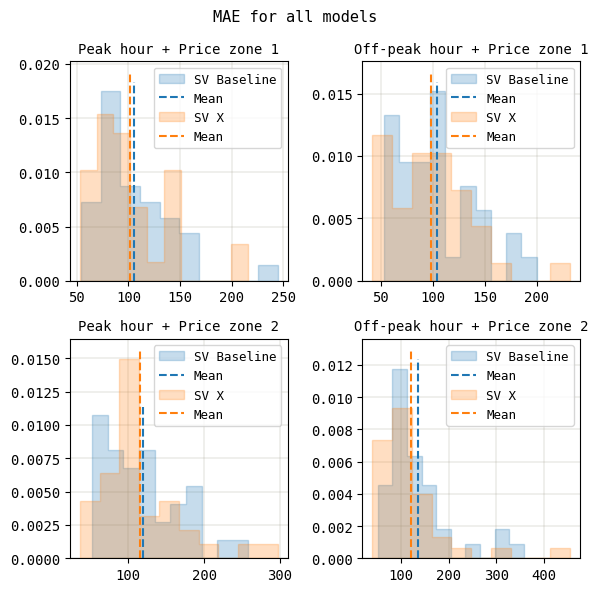

In [121]:
plt.figure(figsize=(6, 6))
for i, subset in zip(range(1, 5), [cv_results_peak_eur, cv_results_offpeak_eur, cv_results_peak_sib, cv_results_offpeak_sib]):
    plt.subplot(2, 2, i)
    plt.hist(subset[subset['model_kind'] == 'sv_base']['test_mae'], bins=10, density=True, histtype='stepfilled', color='C0', edgecolor='C0', alpha=0.25, label='SV Baseline')
    plt.vlines(subset[subset['model_kind'] == 'sv_base']['test_mae'].mean(), ymin=0, ymax=plt.ylim()[1], color='C0', ls='--', label='Mean')
    plt.hist(subset[subset['model_kind'] == 'sv_x']['test_mae'], bins=10, density=True, histtype='stepfilled', color='C1', edgecolor='C1', alpha=0.25, label='SV X')
    plt.vlines(subset[subset['model_kind'] == 'sv_x']['test_mae'].mean(), ymin=0, ymax=plt.ylim()[1], color='C1', ls='--', label='Mean')
    plt.xticks(size=10, family='monospace')
    plt.yticks(size=10, family='monospace')
    plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
    plt.title(f"{' + '.join(subset['model_name'].unique()[0].split(' + ')[1:])}", size=10, family='monospace')
    plt.grid(lw=0.25, color='xkcd:cement')
    plt.gca().set_axisbelow(True)
plt.suptitle(f'MAE for all models', size=11, family='monospace')
plt.tight_layout();

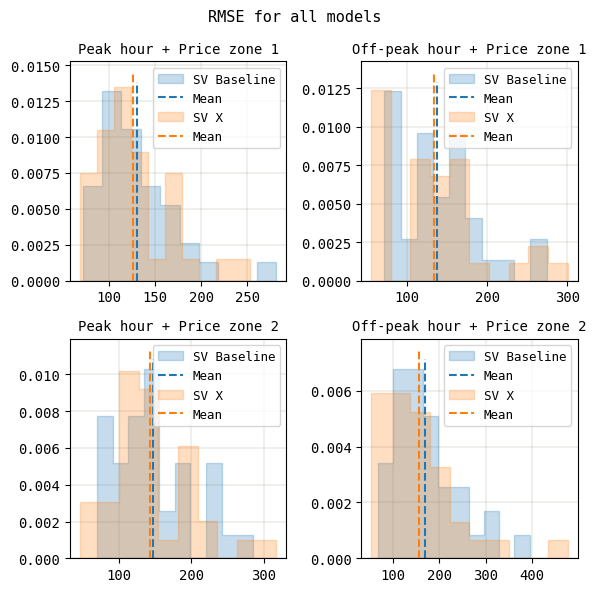

In [122]:
plt.figure(figsize=(6, 6))
for i, subset in zip(range(1, 5), [cv_results_peak_eur, cv_results_offpeak_eur, cv_results_peak_sib, cv_results_offpeak_sib]):
    plt.subplot(2, 2, i)
    plt.hist(subset[subset['model_kind'] == 'sv_base']['test_rmse'], bins=10, density=True, histtype='stepfilled', color='C0', edgecolor='C0', alpha=0.25, label='SV Baseline')
    plt.vlines(subset[subset['model_kind'] == 'sv_base']['test_rmse'].mean(), ymin=0, ymax=plt.ylim()[1], color='C0', ls='--', label='Mean')
    plt.hist(subset[subset['model_kind'] == 'sv_x']['test_rmse'], bins=10, density=True, histtype='stepfilled', color='C1', edgecolor='C1', alpha=0.25, label='SV X')
    plt.vlines(subset[subset['model_kind'] == 'sv_x']['test_rmse'].mean(), ymin=0, ymax=plt.ylim()[1], color='C1', ls='--', label='Mean')
    plt.xticks(size=10, family='monospace')
    plt.yticks(size=10, family='monospace')
    plt.legend(loc='upper right', prop={'size': 9, 'family': 'monospace'})
    plt.title(f"{' + '.join(subset['model_name'].unique()[0].split(' + ')[1:])}", size=10, family='monospace')
    plt.grid(lw=0.25, color='xkcd:cement')
    plt.gca().set_axisbelow(True)
plt.suptitle(f'RMSE for all models', size=11, family='monospace')
plt.tight_layout();

In [123]:
# Two independent samples one-tailed t-test for the means
ttest_ind(cv_results_sv_base_df['test_rmse'], cv_results_sv_x_df['test_rmse'], alternative='greater')

TtestResult(statistic=0.8779530618675015, pvalue=0.19035306650577766, df=286.0)

In [124]:
# Two independent samples Mann-Whitney U test
mannwhitneyu(cv_results_sv_base_df['test_rmse'], cv_results_sv_x_df['test_rmse'], alternative='greater')

MannwhitneyuResult(statistic=11196.0, pvalue=0.12080463588328066)

Metrics for both models have heavy right tails, which signals that the models were not good for all splits. This might be due to market regime change or other factors.

In [125]:
print(' Train / test fold with best RMSE:', price_temp_data_peak_eur.iloc[cv_results_sv_base_df[cv_results_sv_base_df['test_rmse'] == cv_results_sv_base_df['test_rmse'].min()]['train_indices'].values[0]].index.min().date(),\
'--', price_temp_data_peak_eur.iloc[cv_results_sv_base_df[cv_results_sv_base_df['test_rmse'] == cv_results_sv_base_df['test_rmse'].min()]['train_indices'].values[0]].index.max().date(), end=' / ')

print(price_temp_data_peak_eur.iloc[cv_results_sv_base_df[cv_results_sv_base_df['test_rmse'] == cv_results_sv_base_df['test_rmse'].min()]['test_indices'].values[0]].index.min().date(),\
'--', price_temp_data_peak_eur.iloc[cv_results_sv_base_df[cv_results_sv_base_df['test_rmse'] == cv_results_sv_base_df['test_rmse'].min()]['test_indices'].values[0]].index.max().date())

print('Train / test fold with worst RMSE:', price_temp_data_peak_eur.iloc[cv_results_sv_base_df[cv_results_sv_base_df['test_rmse'] == cv_results_sv_base_df['test_rmse'].max()]['train_indices'].values[0]].index.min().date(),\
'--', price_temp_data_peak_eur.iloc[cv_results_sv_base_df[cv_results_sv_base_df['test_rmse'] == cv_results_sv_base_df['test_rmse'].max()]['train_indices'].values[0]].index.max().date(), end=' / ')

print(price_temp_data_peak_eur.iloc[cv_results_sv_base_df[cv_results_sv_base_df['test_rmse'] == cv_results_sv_base_df['test_rmse'].max()]['test_indices'].values[0]].index.min().date(),\
'--', price_temp_data_peak_eur.iloc[cv_results_sv_base_df[cv_results_sv_base_df['test_rmse'] == cv_results_sv_base_df['test_rmse'].max()]['test_indices'].values[0]].index.max().date())

 Train / test fold with best RMSE: 2016-09-16 -- 2017-09-11 / 2017-09-12 -- 2017-12-10
Train / test fold with worst RMSE: 2018-09-07 -- 2019-09-01 / 2019-09-02 -- 2019-11-30


The statistical significance of difference in metrics, obtained during cross-validation, between SV Baseline and SV X models _cannot_ be confirmed by hypothesis testing including two independent samples one-tailed $t$-test and two independent samples Mann-Whitney U test.

[Back](#toc)

---
##### <a id="results"></a>5. Results

In [126]:
cv_results_peak_eur.groupby('model_kind')[['test_mae', 'test_rmse']].mean().T.style.highlight_min(color='palegreen', axis=1).set_caption(f'<h4>Peak hour + Price zone 1</h4>')

model_kind,sv_base,sv_x
test_mae,105.385055,101.093663
test_rmse,130.526412,125.732587


In [127]:
cv_results_peak_sib.groupby('model_kind')[['test_mae', 'test_rmse']].mean().T.style.highlight_min(color='palegreen', axis=1).set_caption(f'<h4>Peak hour + Price zone 2</h4>')

model_kind,sv_base,sv_x
test_mae,119.140971,115.857868
test_rmse,146.445320,143.087490


In [128]:
cv_results_offpeak_eur.groupby('model_kind')[['test_mae', 'test_rmse']].mean().T.style.highlight_min(color='palegreen', axis=1).set_caption(f'<h4>Off-peak hour + Price zone 1</h4>')

model_kind,sv_base,sv_x
test_mae,104.422811,98.085944
test_rmse,137.501447,133.830062


In [129]:
cv_results_offpeak_sib.groupby('model_kind')[['test_mae', 'test_rmse']].mean().T.style.highlight_min(color='palegreen', axis=1).set_caption(f'<h4>Off-peak hour + Price zone 2</h4>')

model_kind,sv_base,sv_x
test_mae,134.863451,121.031701
test_rmse,168.305299,155.041461


In [130]:
# MAE % improvement
print(f"{cv_results_sv_base_df['test_mae'].mean() / cv_results_sv_x_df['test_mae'].mean() - 1:.2%}")

6.36%


In [131]:
# RMSE % improvement
print(f"{cv_results_sv_base_df['test_rmse'].mean() / cv_results_sv_x_df['test_rmse'].mean() - 1:.2%}")

4.50%


**On average, all four SV X models have better MAE (-6.36%) and RMSE (-4.50%) metrics as compared with SV Baseline models obtained during cross-validation.** However, the statistical significance of this difference cannot be confirmed by hypothesis testing including two independent samples one-tailed $t$-test and two independent samples Mann-Whitney U test.

[Back](#toc)